In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [5]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
# Make sure we have halo information for this z... hop/...
num = 73 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 10.0

print("Using astropy cosmology: physical size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_critdm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

Using astropy cosmology: physical size 384.12 kpc
Physical Boxsize from kKey file = 383.42 kpc
rho_critdm,z = 2.799e-27 g / cm3


22

In [6]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [7]:
dmPartMass = 5.58e4 * Odm / h0 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 17447.32 solMass


In [8]:
# Example computation... 
haloTotMass = dmPartMass * 50863 # Halo 0, z=12
overDens = 100.0
size = ((haloTotMass * 3.0/(4.0 * ma.pi) * 1.0/(rho_critDMz * overDens))**(1.0/3.0)).to(u.kpc) * (1 + z)
# size = size * 0.5
size

<Quantity 40.85630933965904 kpc>

In [9]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


36

In [10]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
print("max sp Z {:.2e} mass frac".format(max(Z) * 0.02))

base age 487.19
min sp age 1.45 Myr
max sp age 288.09 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.90e-01 Solar
max sp Z 3.81e-03 mass frac


In [11]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 10.0, 0.0213 arcsec / kpc:
Proper to 10.0, 0.2340 arcsec / kpc:
Proper to 10.0, 4.2743 kpc / arcsec:
My Comoving @ 10.0, 0.0213 arcsec / kpc:
My Proper to 10.0, 0.2340 arcsec / kpc:
My Proper to 10.0, 4.2743 kpc / arcsec:


In [12]:
myCosmo.age(z)

<Quantity 0.48455407831727154 Gyr>

In [13]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates
## ## ## GET FROM hopRick ## ## ##
##
halosRawPos = lsp.loadHaloGrps(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
halossizes = lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
# halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
# halossizes = lsp.loadHaloSizes(num) # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos * 3000.0/h0 # Comoving box 
locs = (locsRaw/boxsizekpc) * 3000.0/h0 # Comoving coords of SPs 
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 10.0 = 133


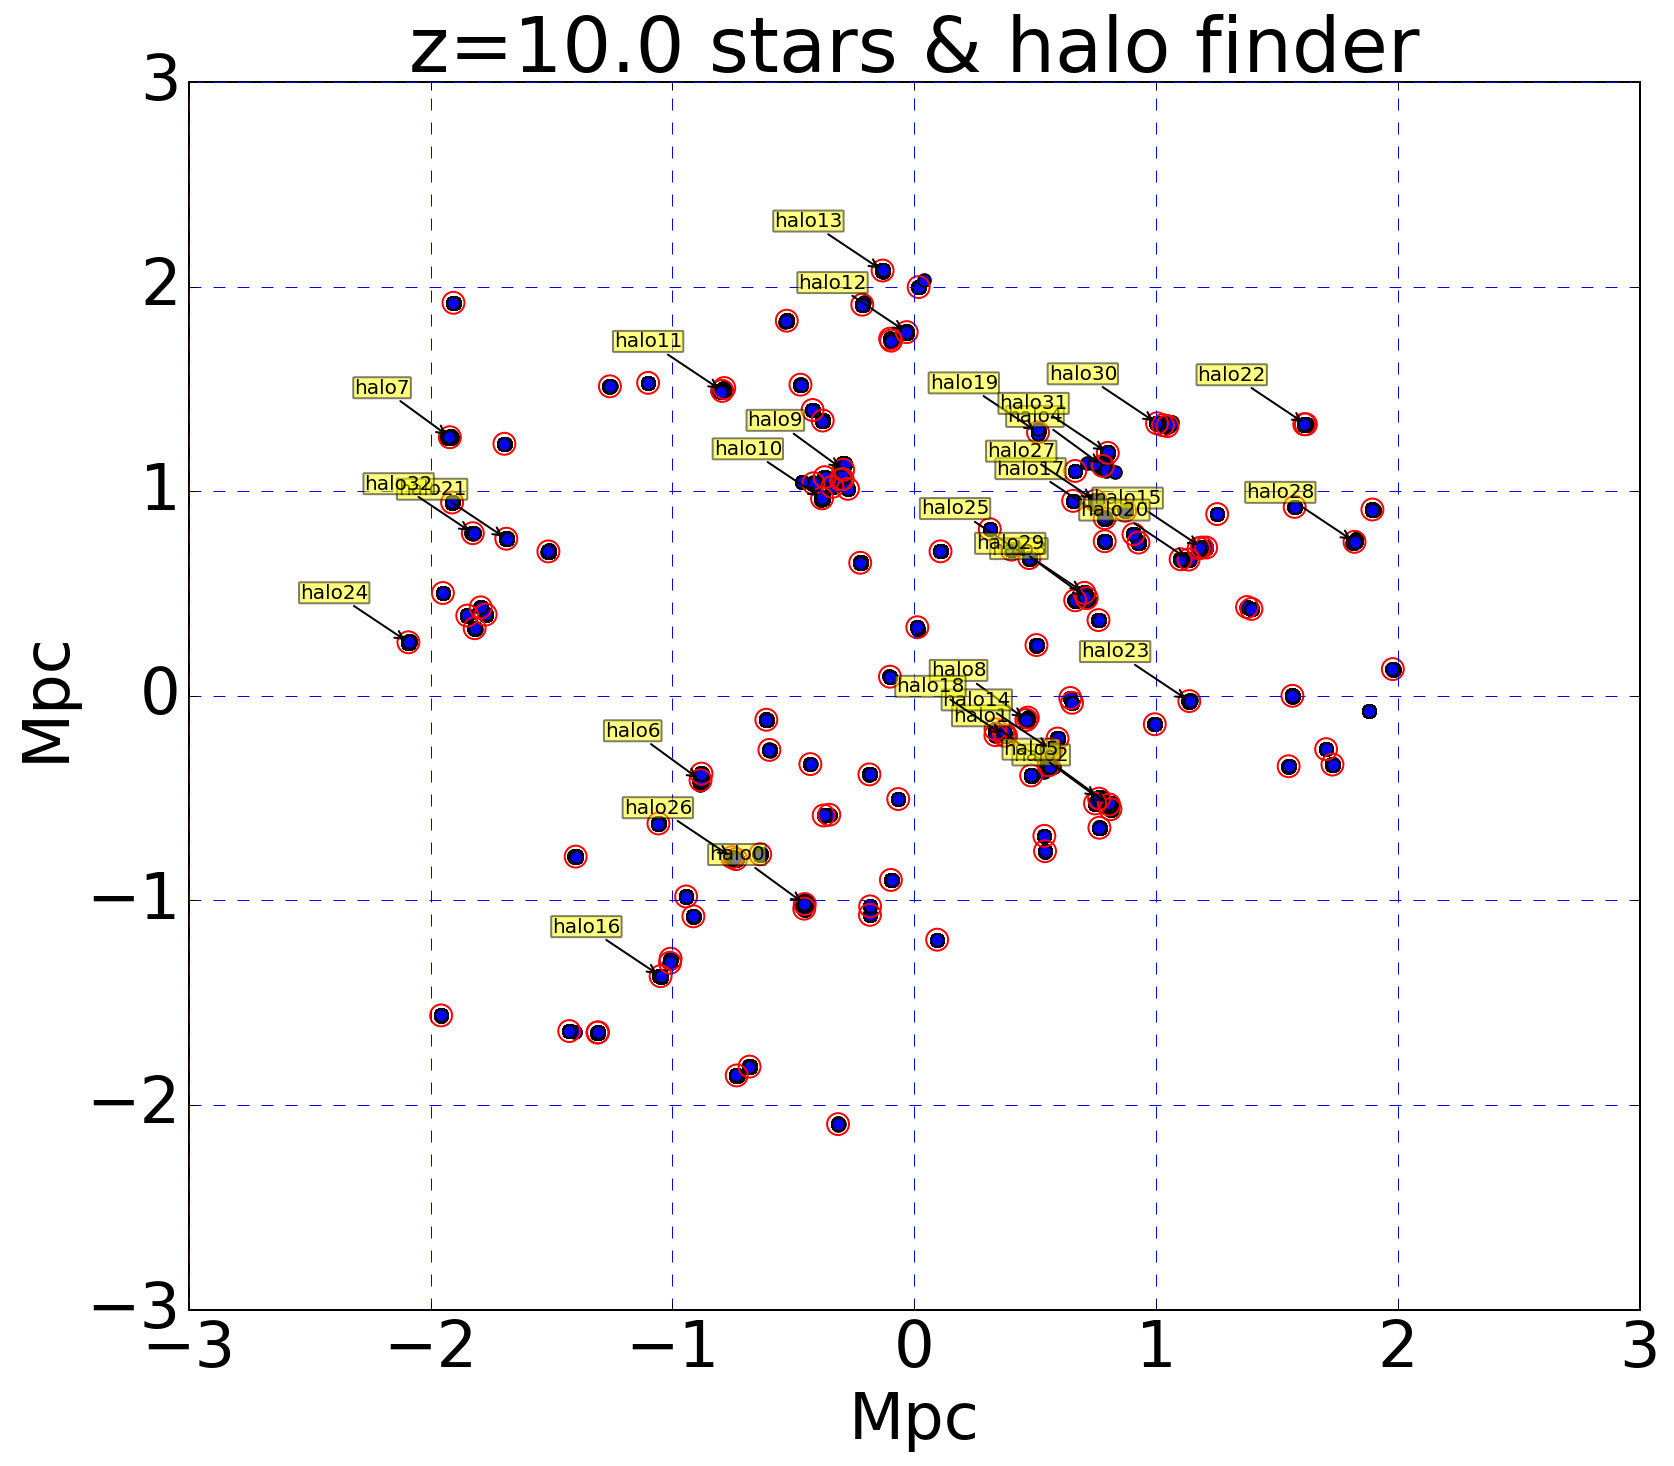

6367

In [14]:
htp = min(500,len(halosRawPos))
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0][:33]/1000,halosPos[:htp,1][:33]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

radius 27.64
Halo 0 mass is 1.88e+07 M_sun


10293

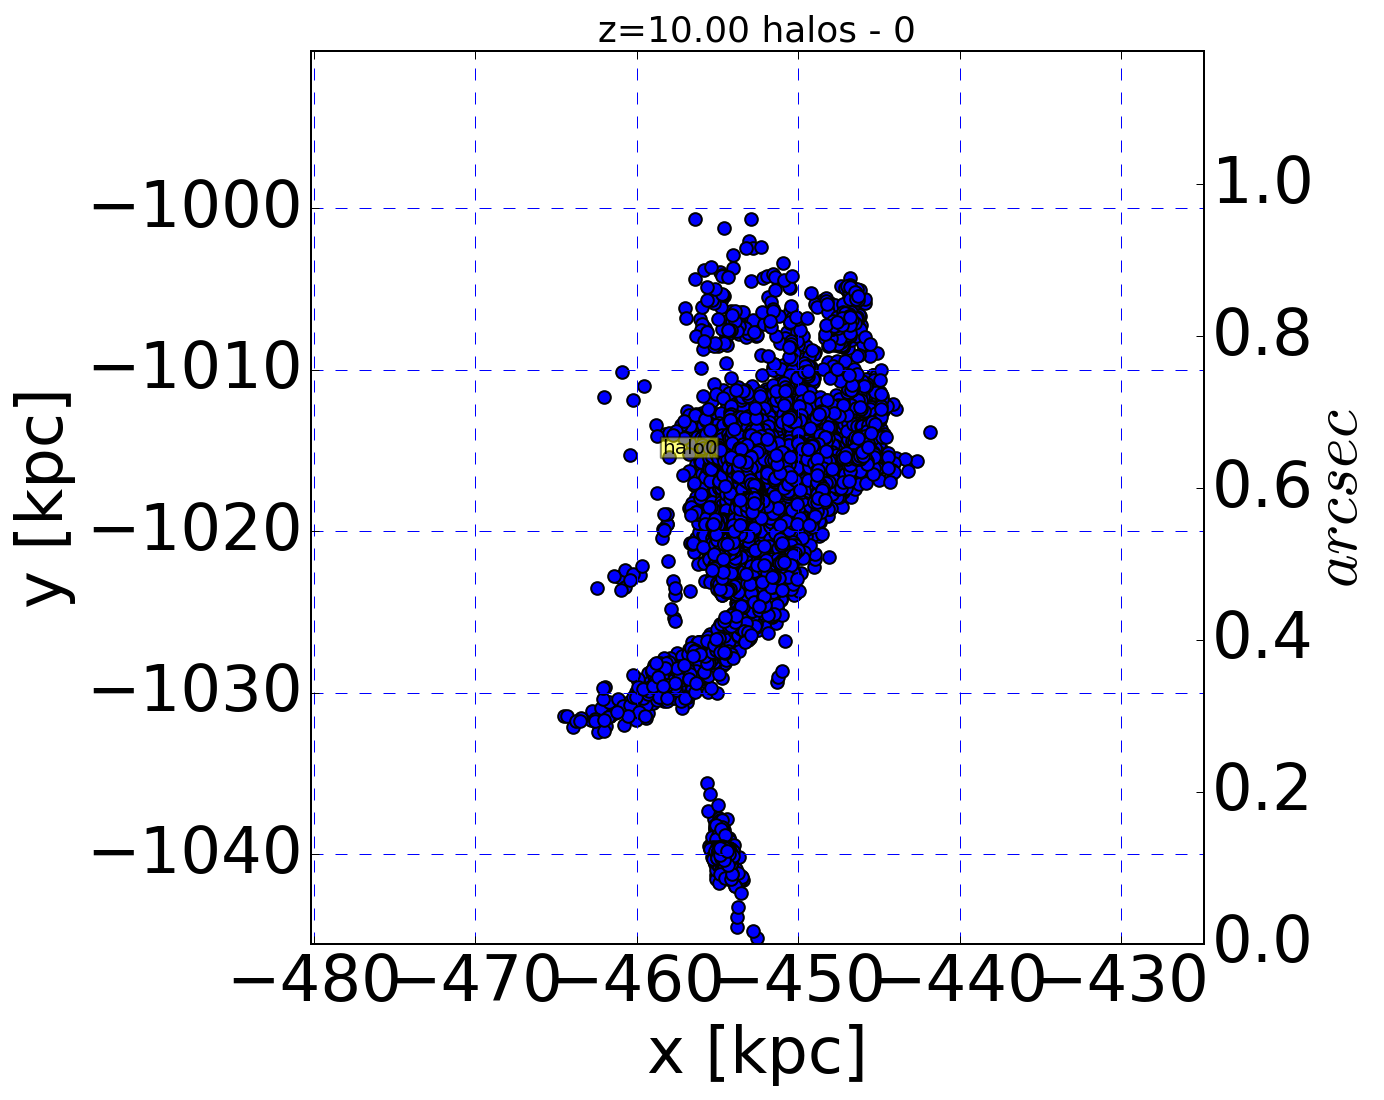

In [20]:
halo = 0
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
radiusScaleFac = 0.95
radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
           1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100 ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
radius = radius.value * radiusScaleFac
print('radius {:.2f}'.format(radius))

haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                      halosPos,halo,r=radius)

print("Halo {} mass is {:.2e} M_sun".format(halo, np.sum(halomass)))
ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
del ax
gc.collect()

In [23]:
overDens = 100.0
radiusScaleFac = 0.75
print("z={}".format(z))
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
#for halo in range(len(halosRawPos)):
for halo in range(100):
    # Remember to compute radius in Comoving coords
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * overDens ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=5)
    if len(halomass) == 0:
        print("SKipping {} since no sps at center...".format(halo))
        continue
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    fig = plt.figure(figsize=(8,8))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    plt.savefig('/Volumes/ASU-2TB-Ext/z{:.1f}/'.format(z)+'galaxy_z_SP_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    plt.clf()
    del ax
    gc.collect()

z=10.0
radius 21.82
Halo mass 0 is 1.88e+07
radius 18.98
Halo mass 1 is 1.20e+07
radius 17.40
Halo mass 2 is 9.72e+06
radius 16.30
Halo mass 3 is 7.91e+06
radius 15.23
Halo mass 4 is 6.14e+06
radius 14.57
Halo mass 5 is 5.80e+06
radius 13.71
Halo mass 6 is 4.51e+06
radius 12.66
Halo mass 7 is 3.51e+06
radius 12.32
Halo mass 8 is 3.40e+06
radius 12.09
Halo mass 9 is 1.62e+06
radius 11.99
Halo mass 10 is 2.99e+06


/Users/earnric/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


radius 11.73
Halo mass 11 is 3.08e+06
radius 11.05
Halo mass 12 is 2.42e+06
radius 10.39
Halo mass 13 is 1.95e+06
radius 10.38
Halo mass 14 is 1.98e+06
radius 10.34
Halo mass 15 is 2.61e+06
radius 10.16
Halo mass 16 is 1.88e+06
radius 10.14
Halo mass 17 is 1.80e+06
radius 9.87
Halo mass 18 is 1.71e+06
radius 9.85
Halo mass 19 is 1.69e+06
radius 9.55
Halo mass 20 is 1.60e+06
radius 9.42
Halo mass 21 is 1.51e+06
radius 9.33
Halo mass 22 is 2.23e+06
radius 9.09
Halo mass 23 is 1.30e+06
radius 8.98
Halo mass 24 is 1.26e+06
radius 8.86
Halo mass 25 is 1.20e+06
radius 8.83
Halo mass 26 is 1.18e+06
radius 8.79
Halo mass 27 is 1.18e+06
radius 8.74
Halo mass 28 is 1.15e+06
radius 8.73
Halo mass 29 is 1.16e+06
radius 8.69
Halo mass 30 is 1.19e+06
radius 8.56
Halo mass 31 is 1.09e+06
radius 8.47
Halo mass 32 is 1.05e+06
radius 8.42
Halo mass 33 is 1.07e+06
radius 8.28
Halo mass 34 is 9.90e+05
radius 8.26
Halo mass 35 is 1.86e+06
radius 8.25
Halo mass 36 is 9.64e+05
radius 8.25
Halo mass 37 is 9.7

###### ax=halos.pltView(locs,halosPos,9,z,40) # x2 since size is full-fov ... size = 2xradius
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
gc.collect()

# So the following uses the halos found using star particles only
This means that the counts in 'halosizes' are for star particles. Since each SP has a different mass, we need
to find the indices of SPs within the virial radius of the halo and get their masses (getHaloStars). This should
be close to the halosizes['count'] assuming most stars at 726 M_sun

In [38]:
print(halossizes['count'][0])
24450 * 726

24450


17750700

Halo 0 r_v=34.91, stellar mass=1.88e+07 M_sun, ~stellar mass=1.78e+07
Halo 1 r_v=30.38, stellar mass=1.20e+07 M_sun, ~stellar mass=1.17e+07
Halo 2 r_v=27.85, stellar mass=9.80e+06 M_sun, ~stellar mass=9.01e+06
Halo 3 r_v=26.08, stellar mass=8.70e+06 M_sun, ~stellar mass=7.40e+06
Halo 4 r_v=24.36, stellar mass=6.14e+06 M_sun, ~stellar mass=6.03e+06
Halo 5 r_v=23.31, stellar mass=5.83e+06 M_sun, ~stellar mass=5.28e+06
Halo 6 r_v=21.94, stellar mass=4.51e+06 M_sun, ~stellar mass=4.40e+06
Halo 7 r_v=20.25, stellar mass=3.51e+06 M_sun, ~stellar mass=3.46e+06
Halo 8 r_v=19.71, stellar mass=3.40e+06 M_sun, ~stellar mass=3.19e+06
Halo 9 r_v=19.35, stellar mass=2.03e+06 M_sun, ~stellar mass=3.02e+06


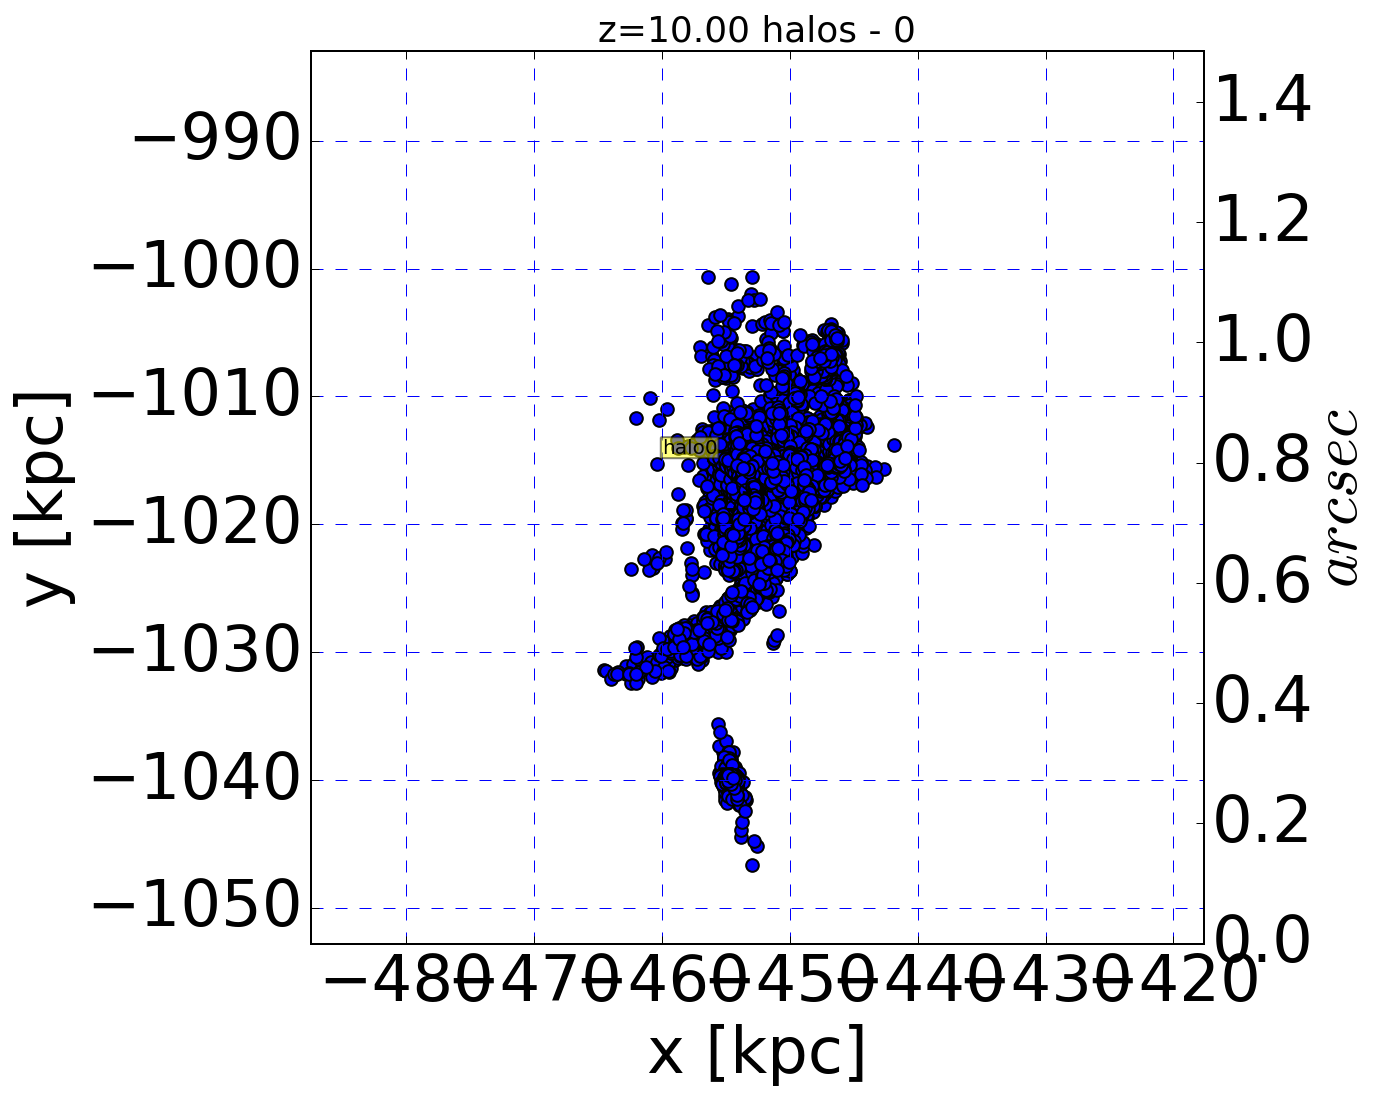

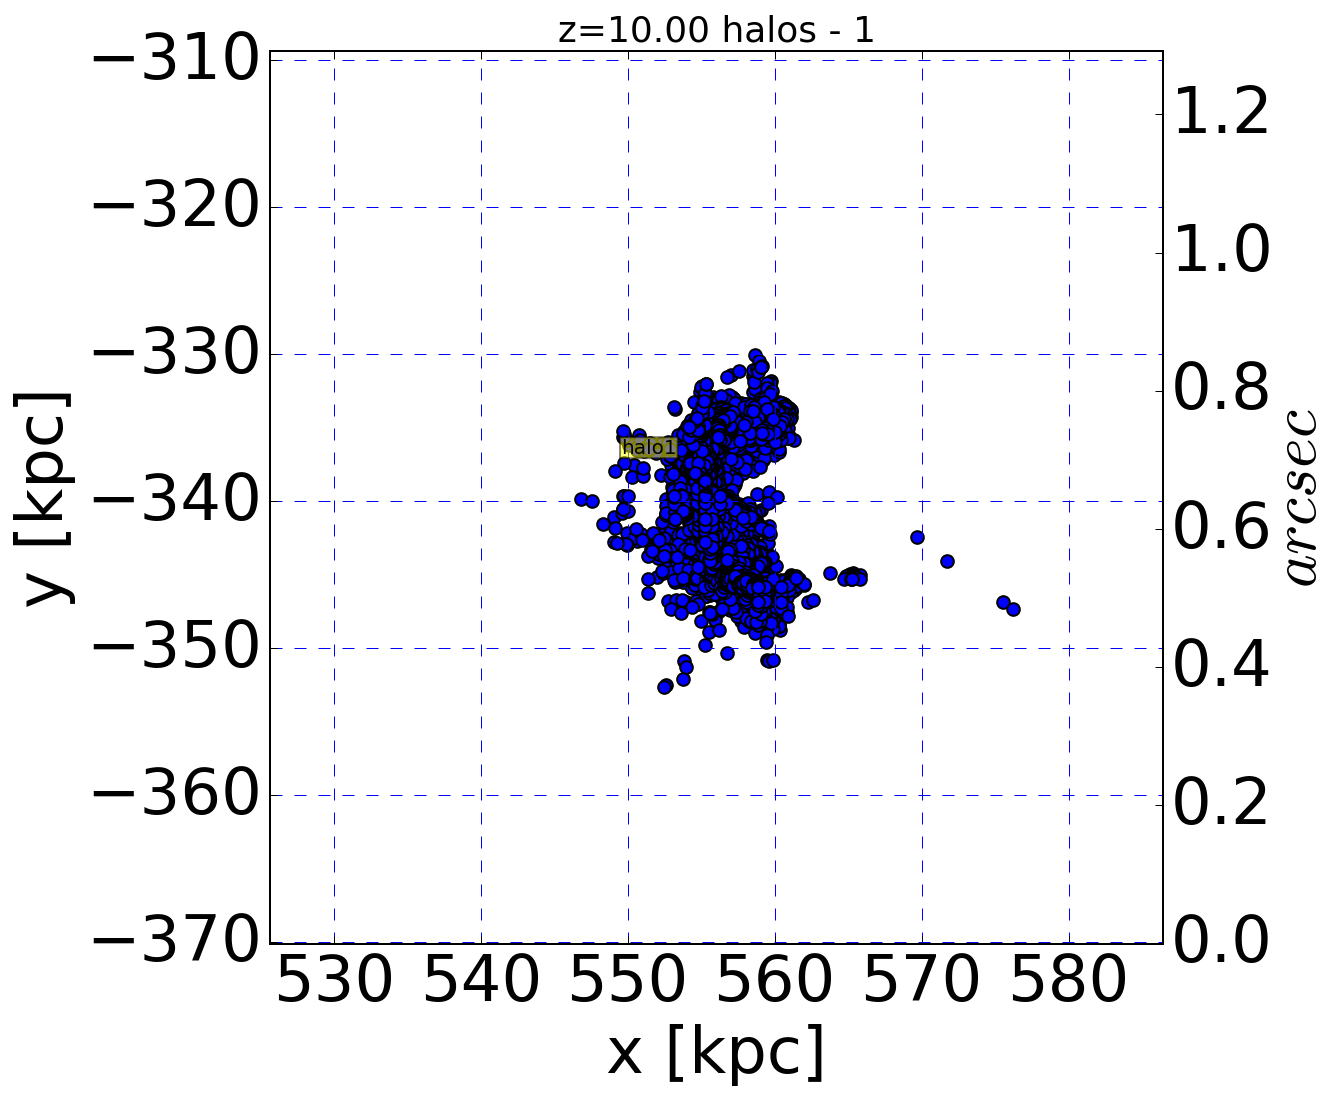

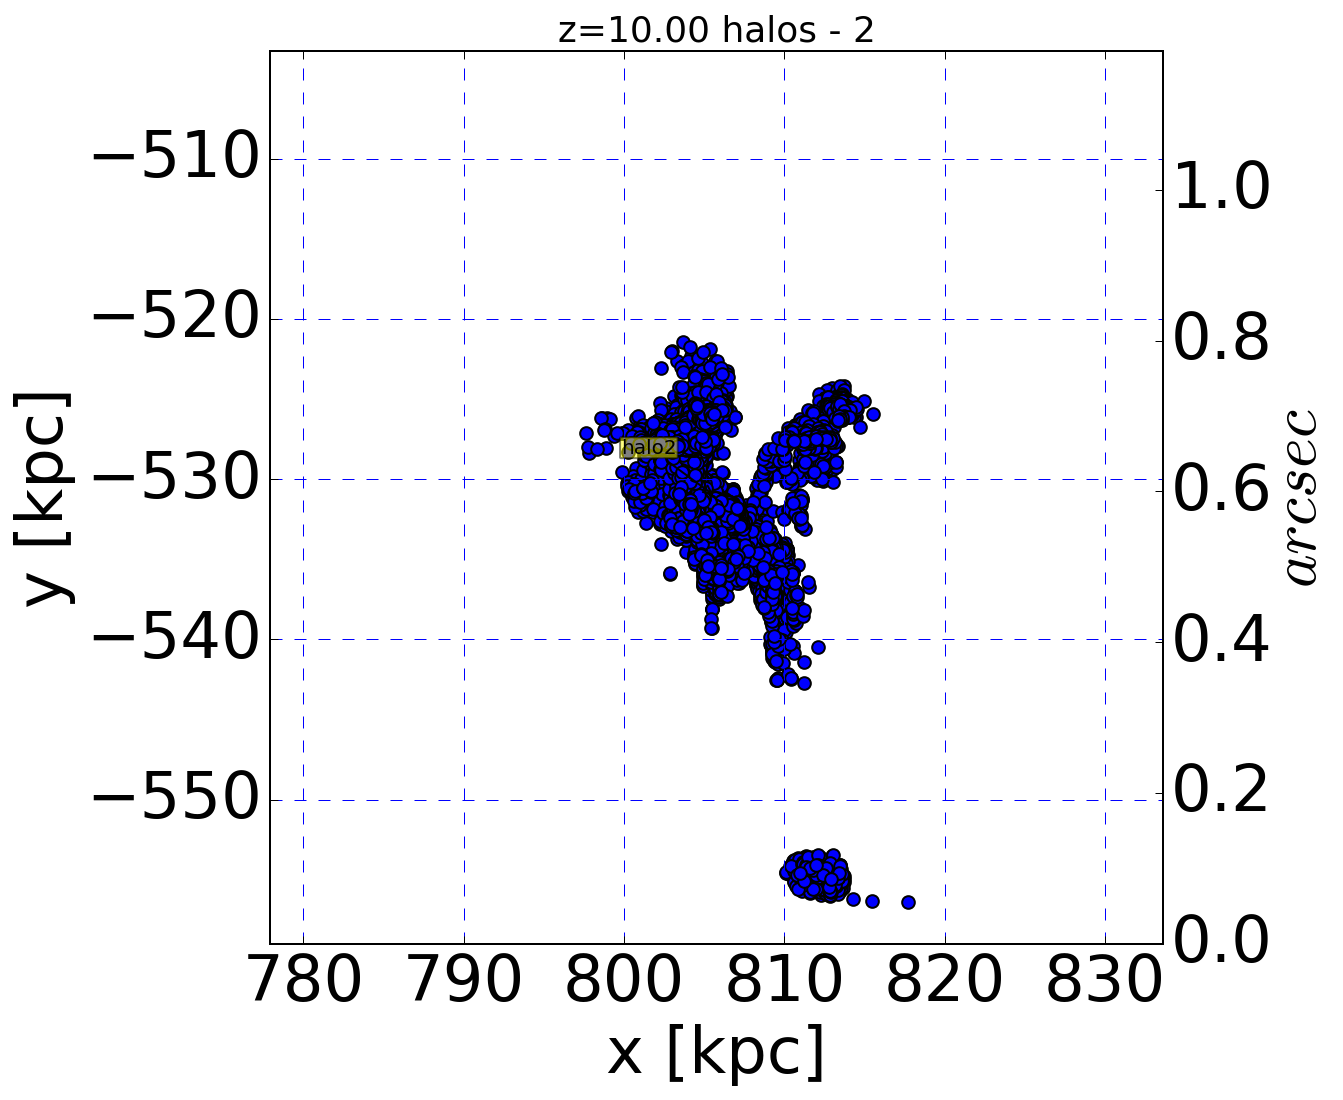

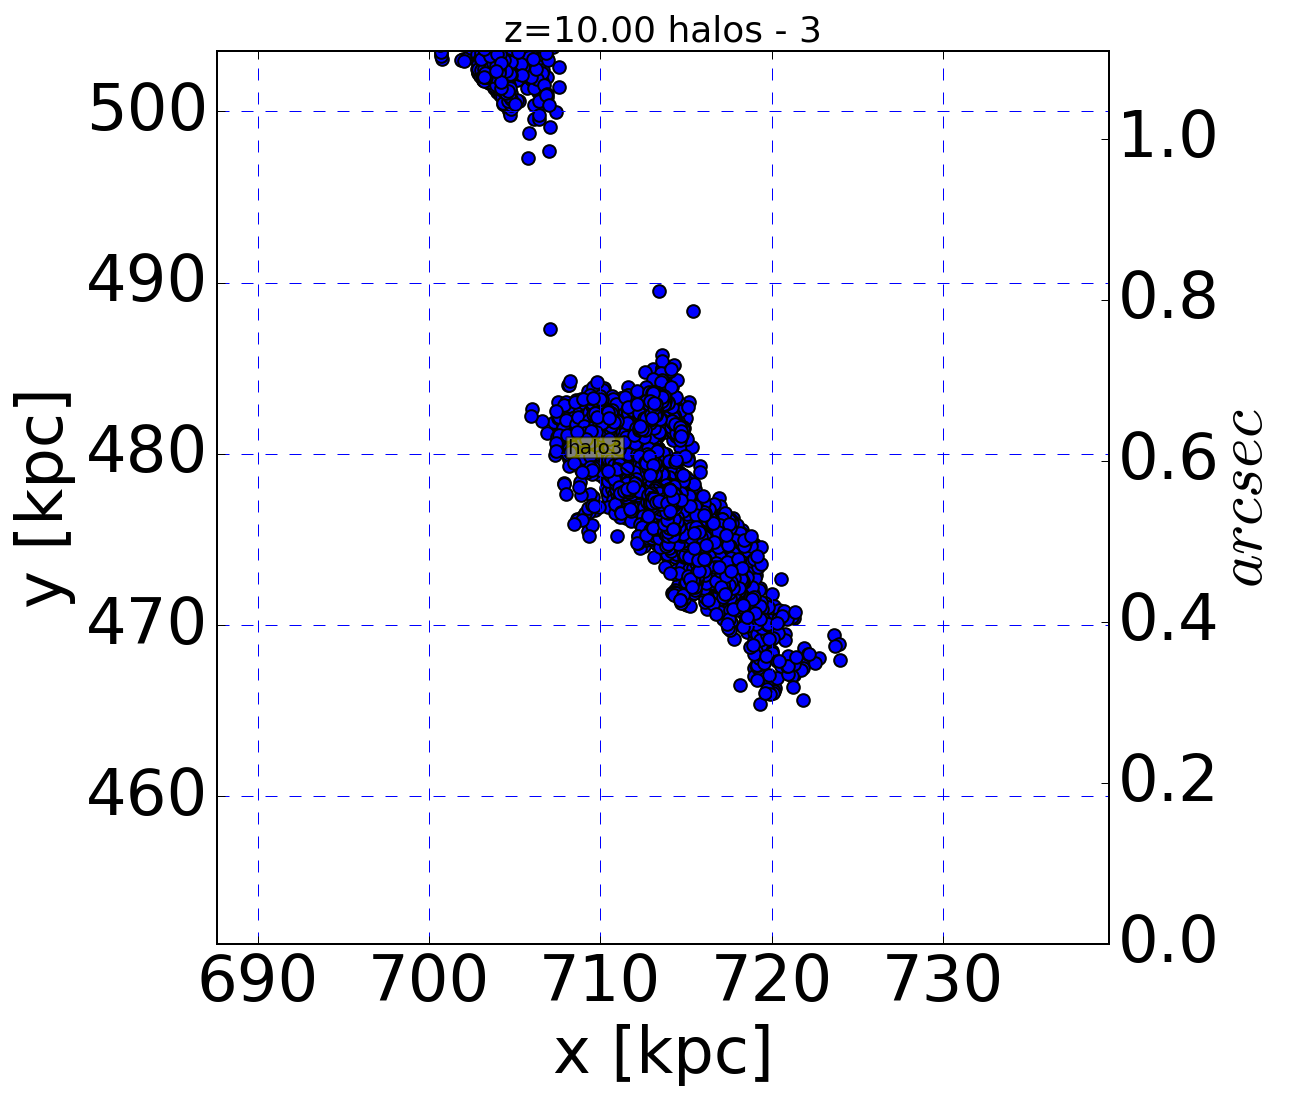

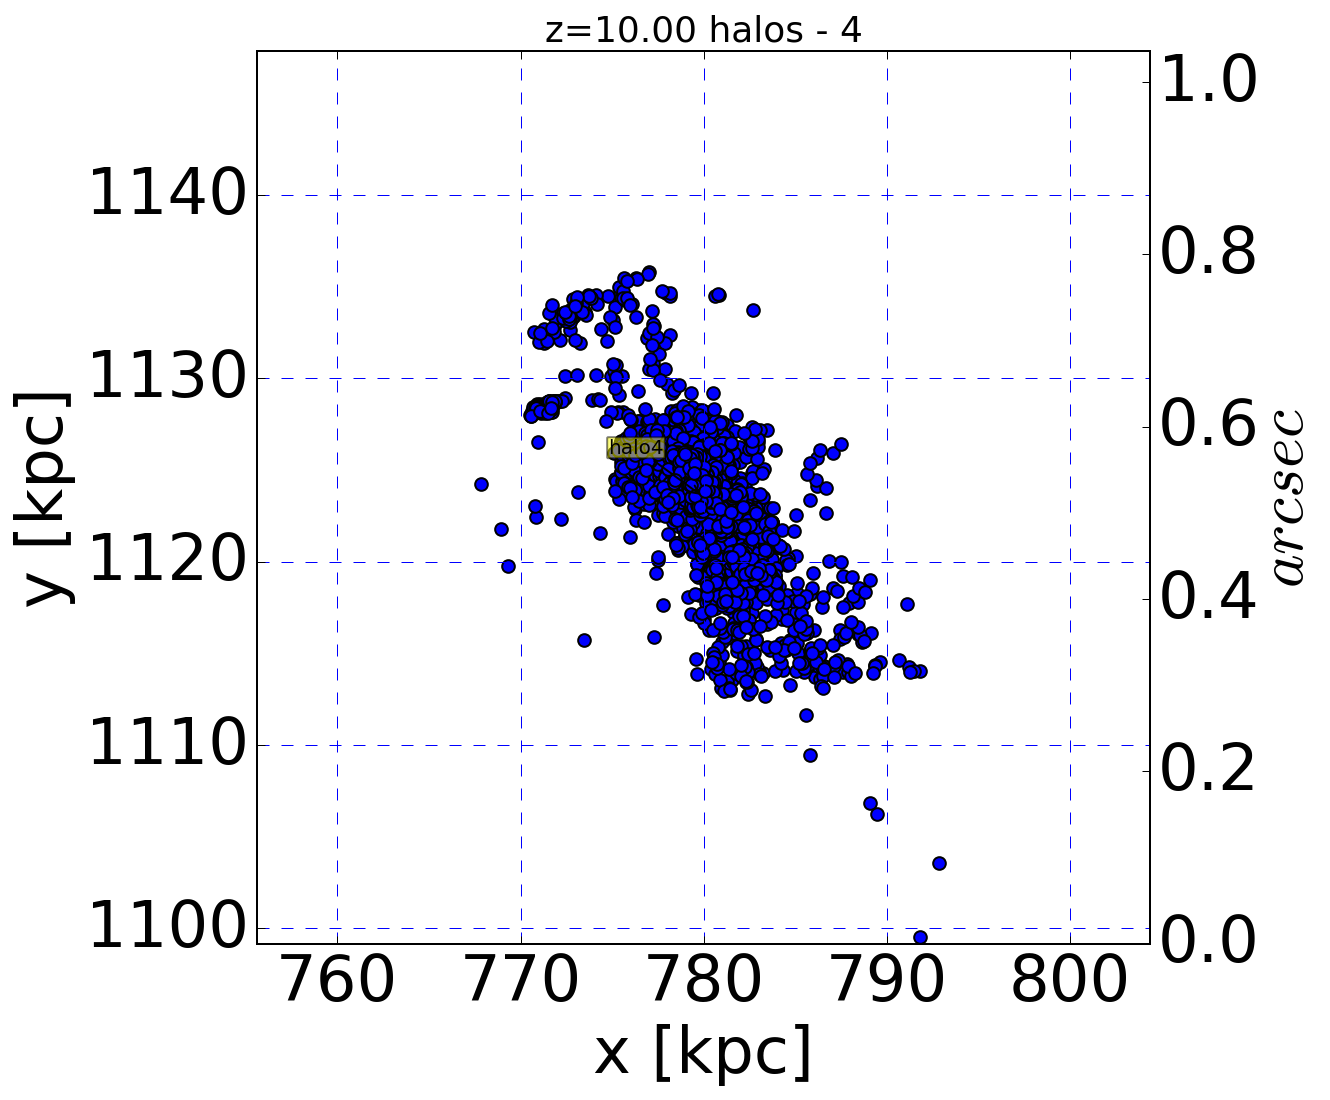

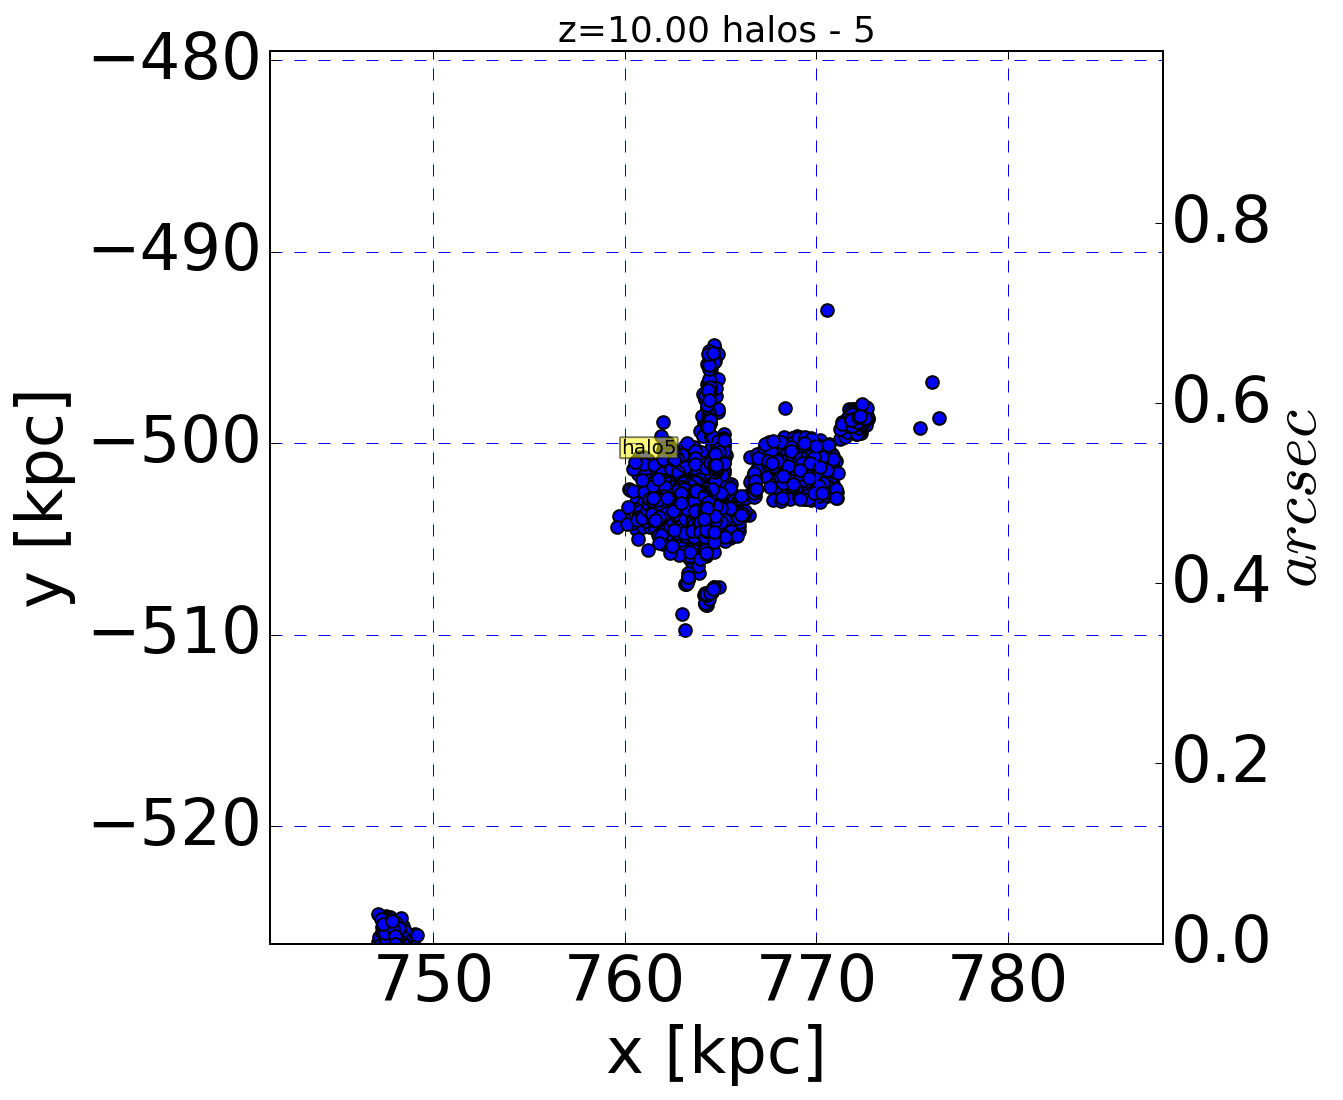

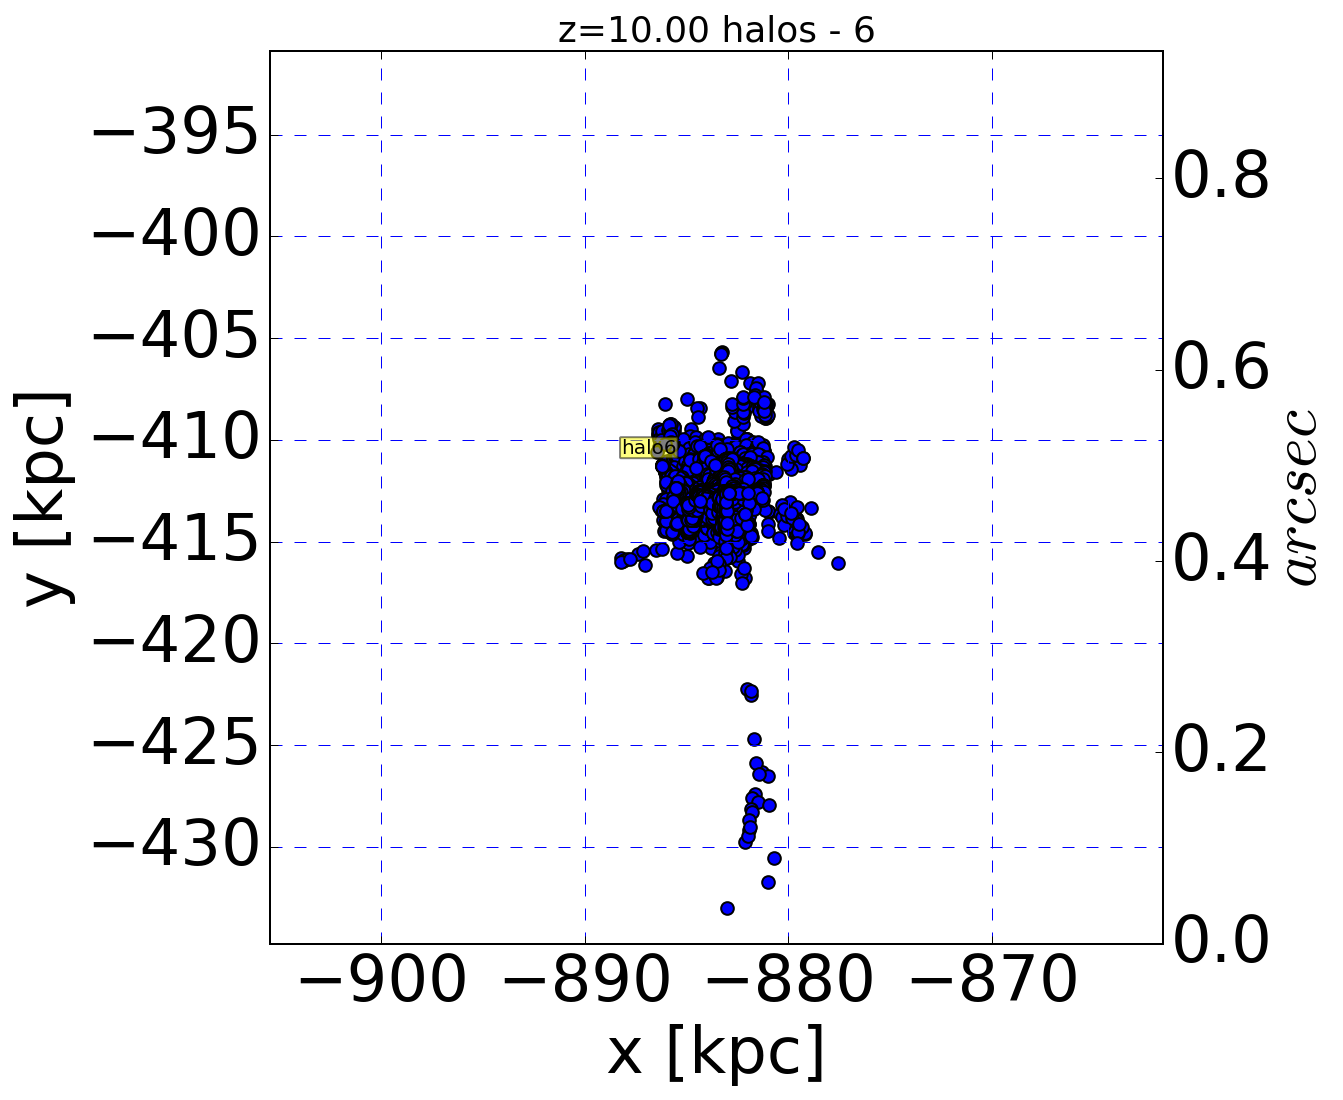

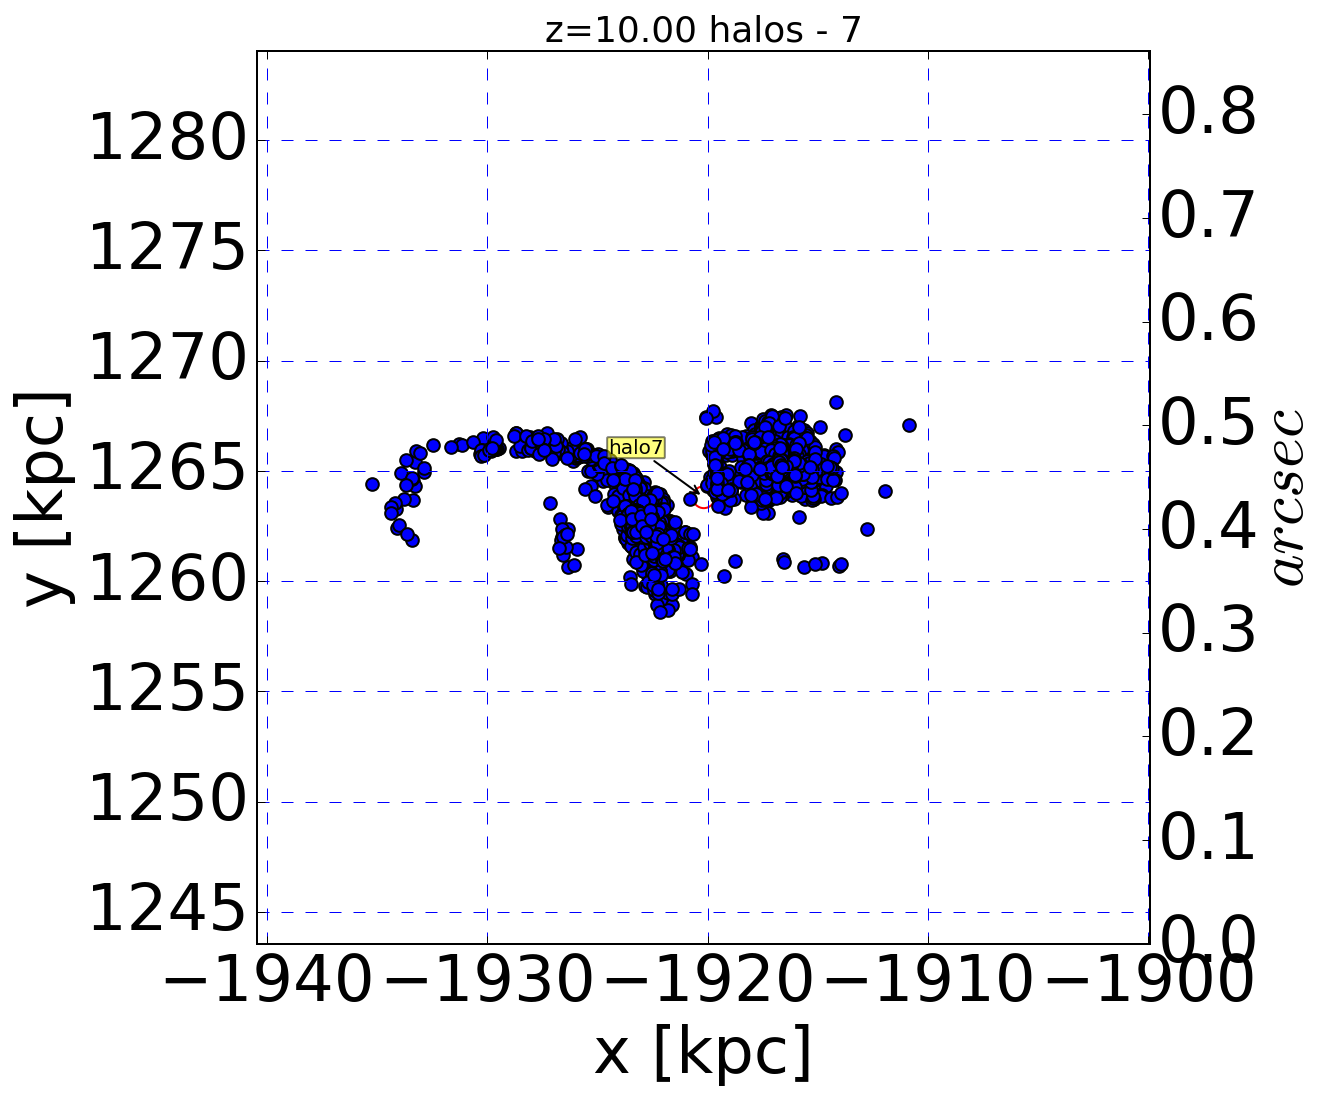

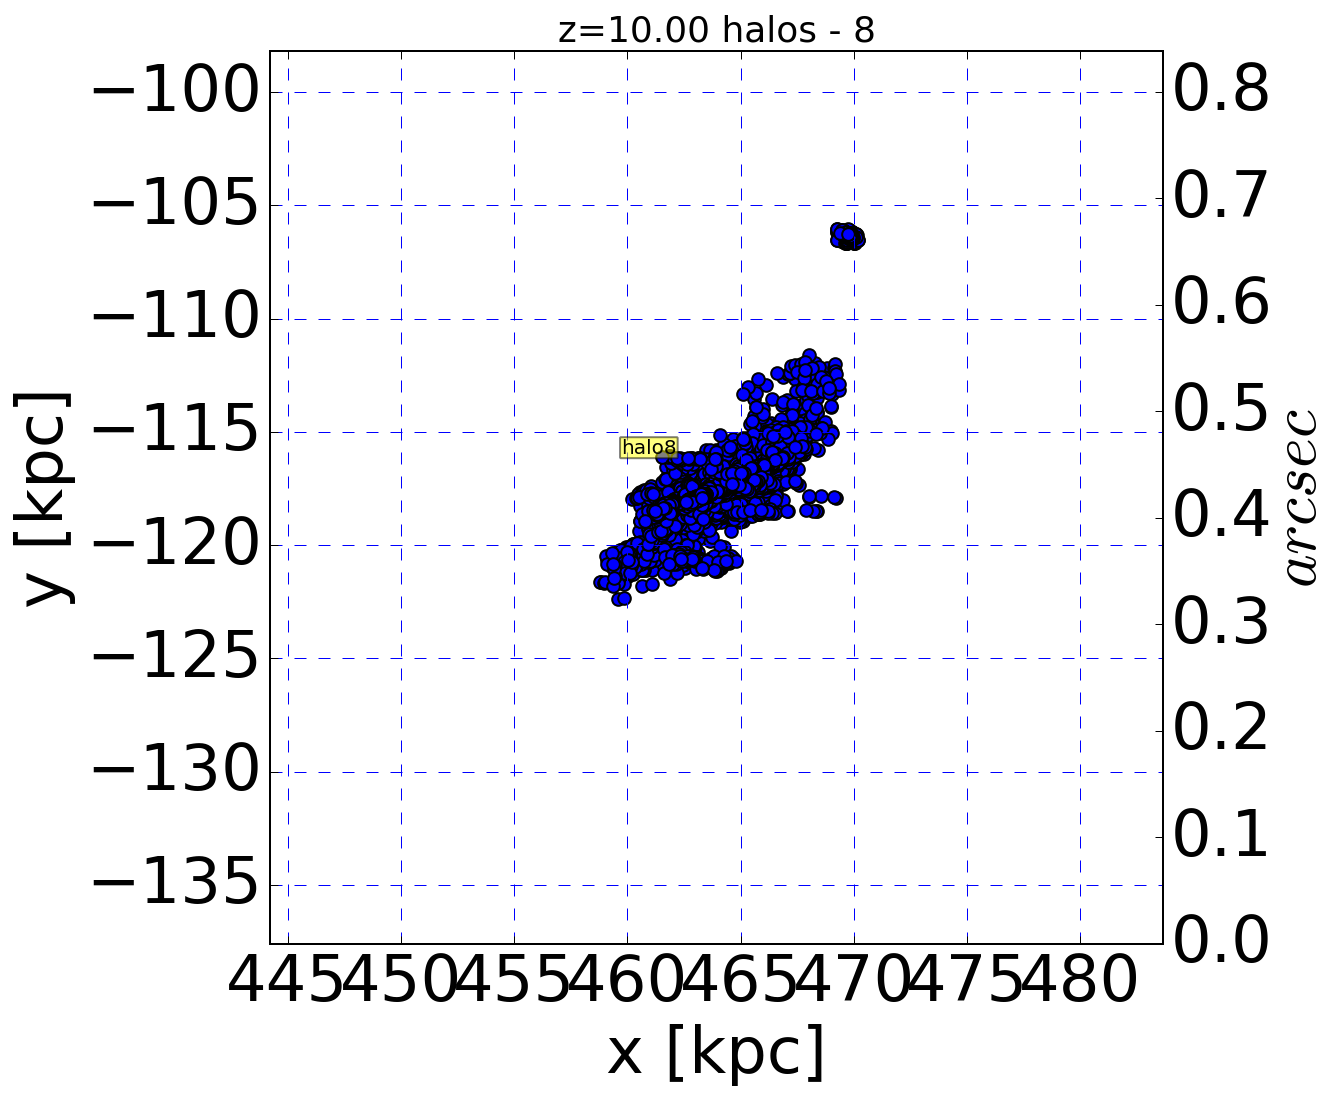

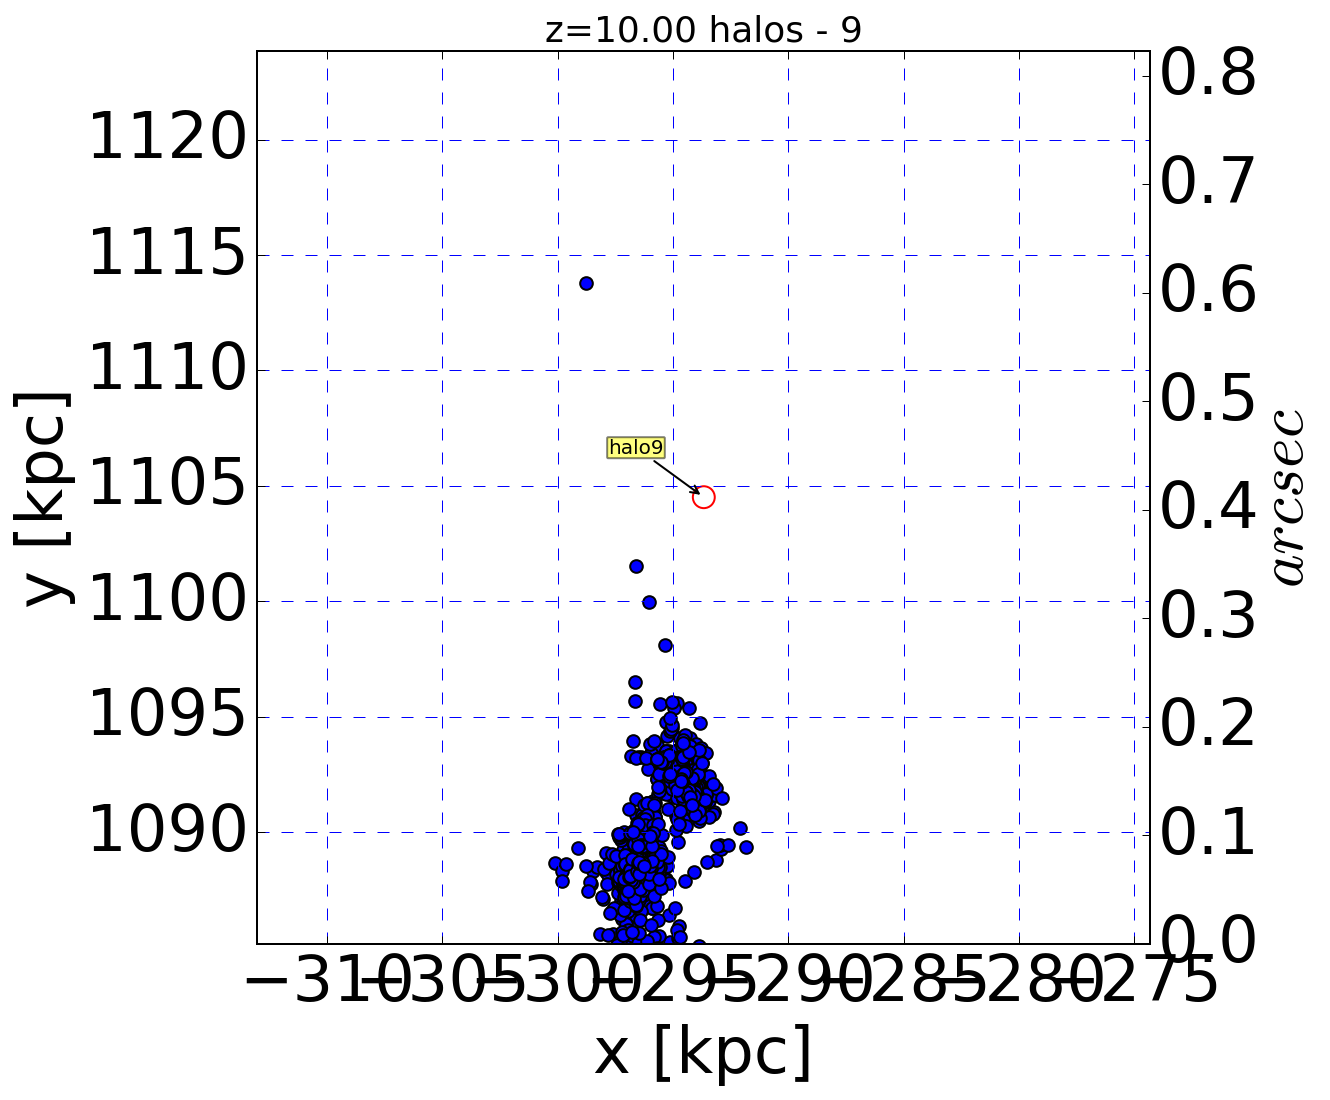

In [44]:
for halo in np.arange(10):
    arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
    radiusScaleFac = 1.2
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100 ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print('Halo {} r_v={:.2f}, stellar mass={:.2e} M_sun, ~stellar mass={:.2e}'.format(halo,
                                                    radius,np.sum(halomass),halossizes['count'][halo]*726))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    del ax
    gc.collect()

In [45]:
halosRawPosDM = lsp.loadHaloGrps(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)
halossizesDM = lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPosDM = halosRawPosDM * 3000.0/h0 # Comoving box 
print("Num of halos @ {} = {} (using DM finder)".format(z,len(halosRawPosDM)))

Num of halos @ 10.0 = 2408 (using DM finder)


## Compute the DM mass of the halos
Use the results of the halo find that looks at DM. The counts in this version of halossizesDM are DM particles.
Compute the virial radius of the halo, find all the stars in that radius (via getHaloStars) and then compute their
total mass... This should be close to the mass above -- probably a bit larger since r_v here is bigger.

Note that the DM mass here should be correct since we have a count of particles in the halo.

Halo 1 r_v=30.83 kpc, stellar mass=1.88e+07, DM mass=1.20e+09 solMass
Halo 0 r_v=32.85 kpc, stellar mass=1.20e+07, DM mass=1.46e+09 solMass
Halo 3 r_v=28.60 kpc, stellar mass=9.80e+06, DM mass=9.61e+08 solMass
Halo 2 r_v=30.75 kpc, stellar mass=8.70e+06, DM mass=1.19e+09 solMass
Halo 4 r_v=26.06 kpc, stellar mass=6.14e+06, DM mass=7.26e+08 solMass
Halo 7 r_v=21.77 kpc, stellar mass=5.80e+06, DM mass=4.23e+08 solMass
Halo 8 r_v=21.65 kpc, stellar mass=4.51e+06, DM mass=4.17e+08 solMass
Halo 9 r_v=21.44 kpc, stellar mass=3.51e+06, DM mass=4.05e+08 solMass
Halo 14 r_v=19.67 kpc, stellar mass=3.40e+06, DM mass=3.12e+08 solMass
Halo 13 r_v=19.79 kpc, stellar mass=1.98e+06, DM mass=3.18e+08 solMass


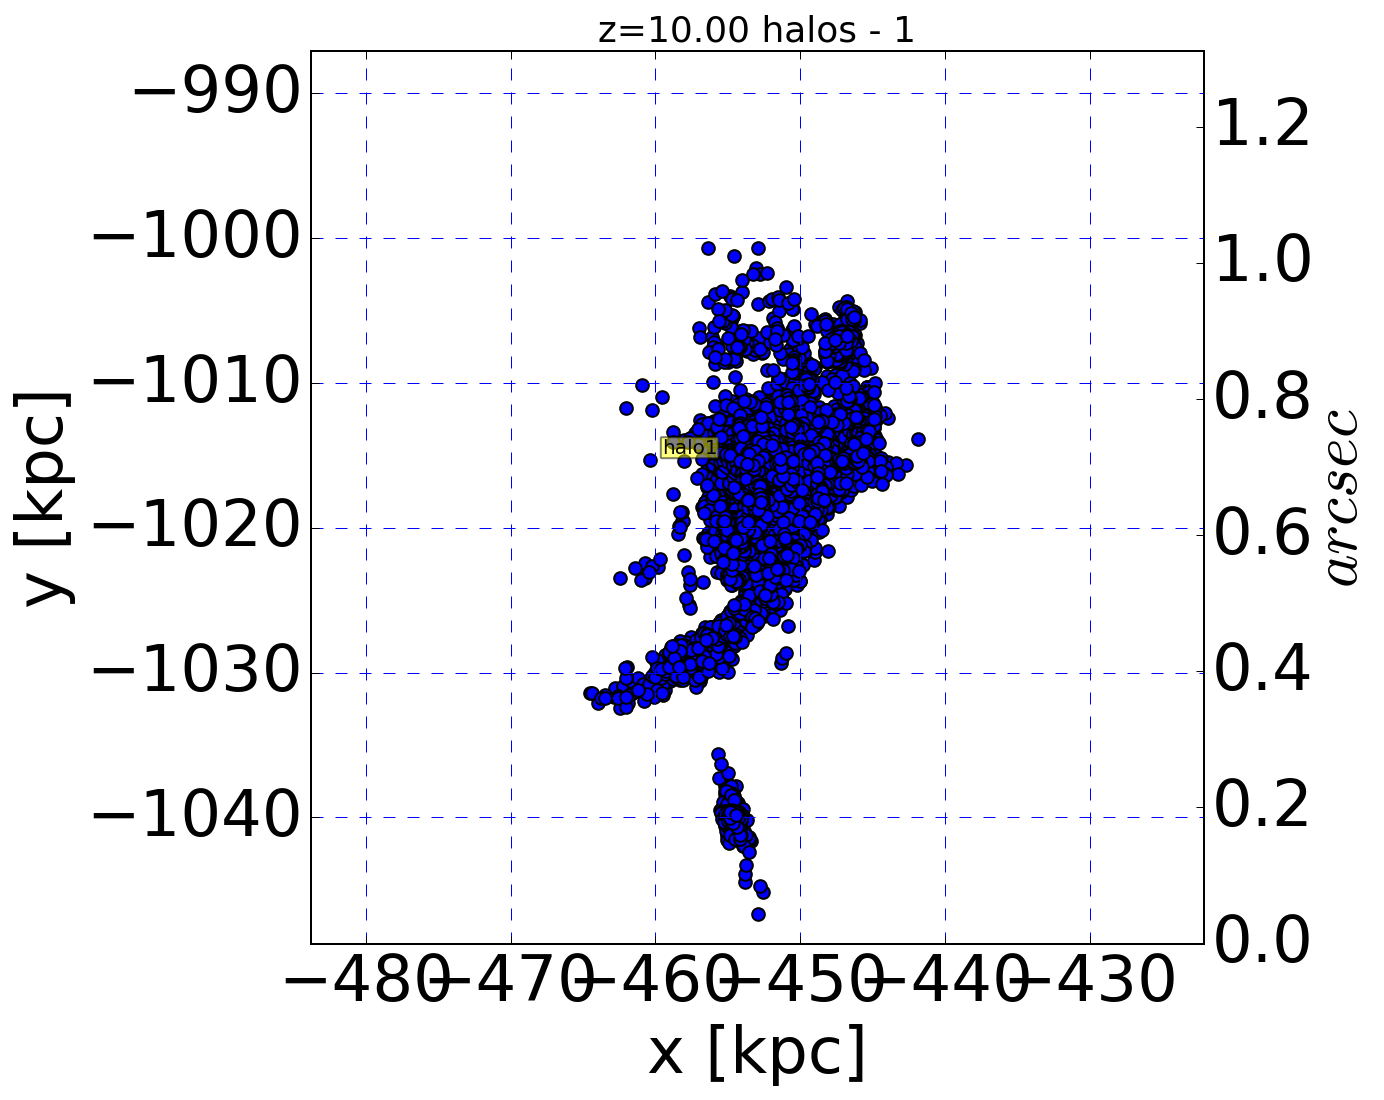

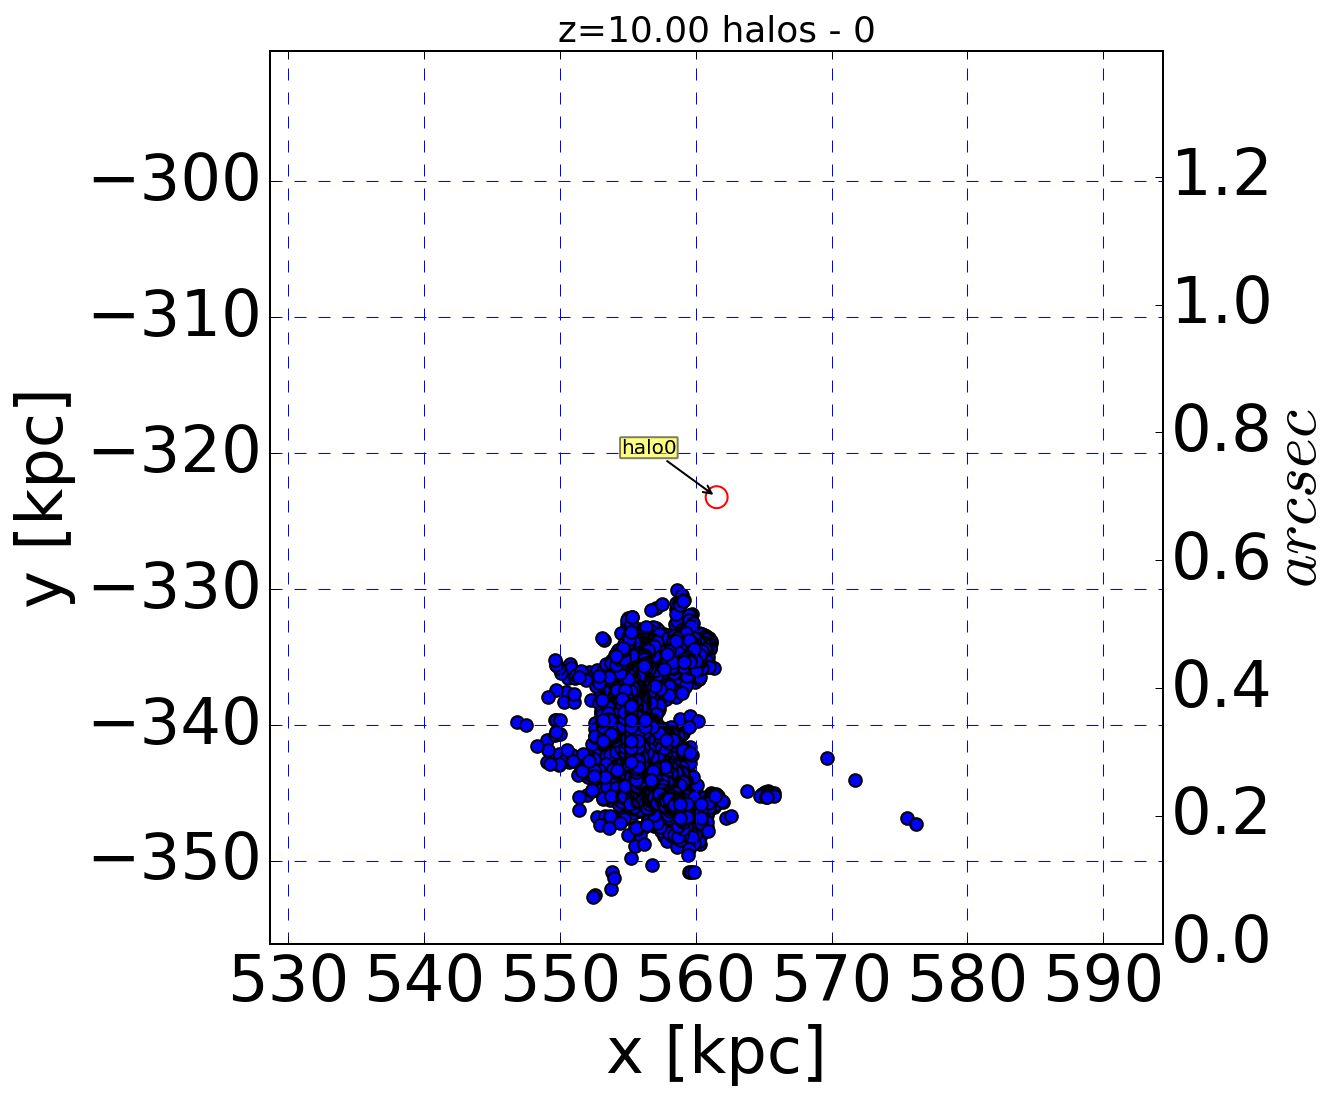

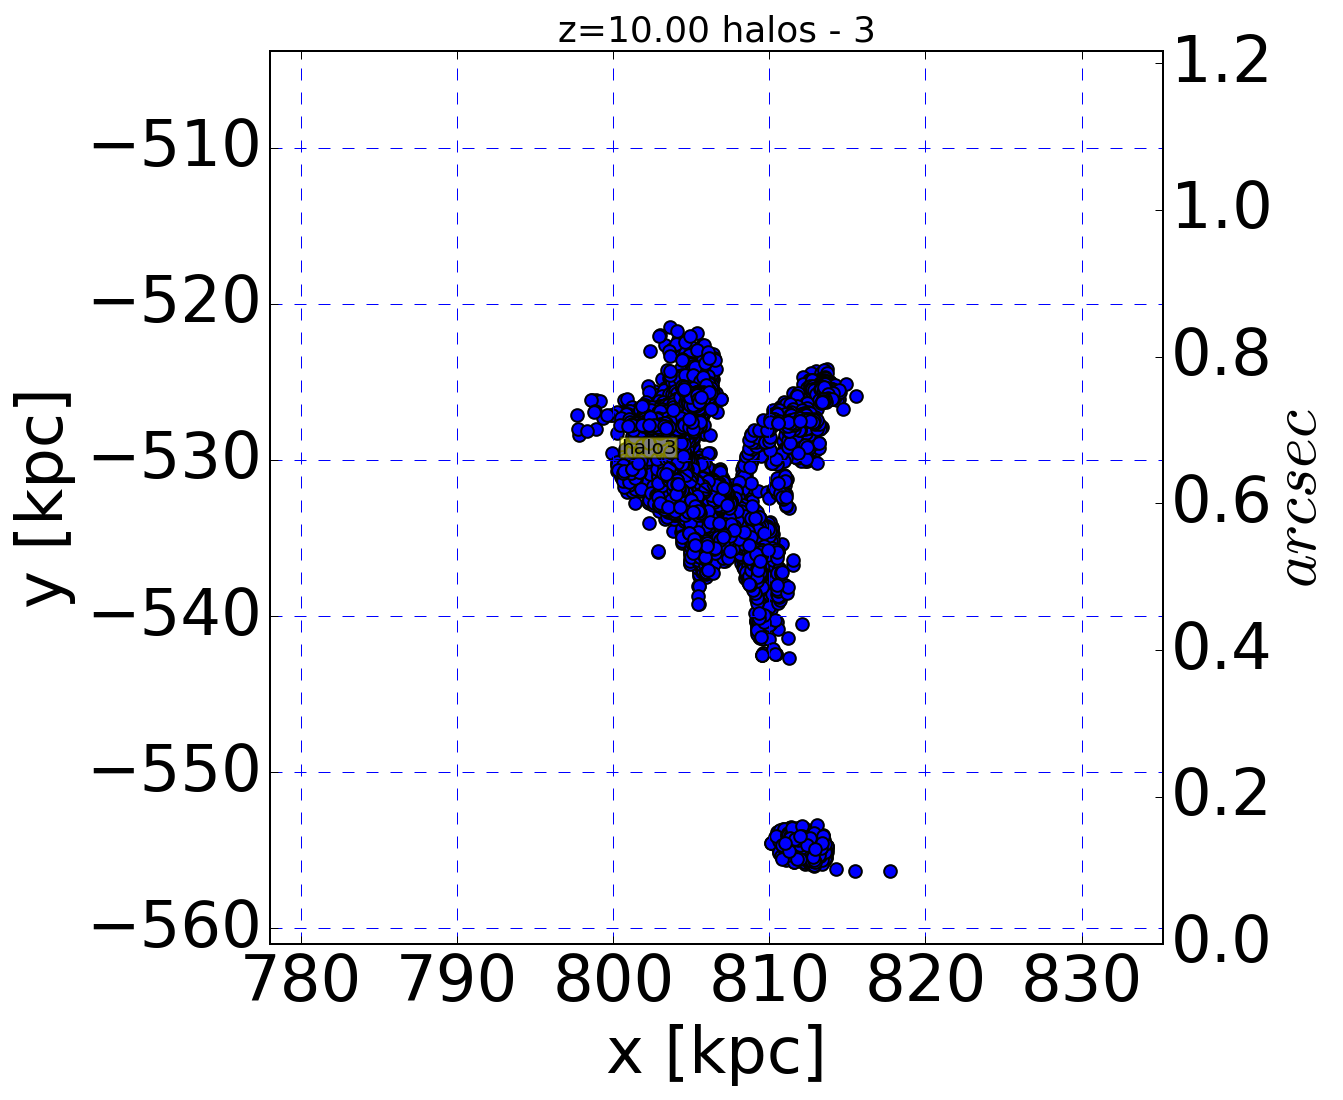

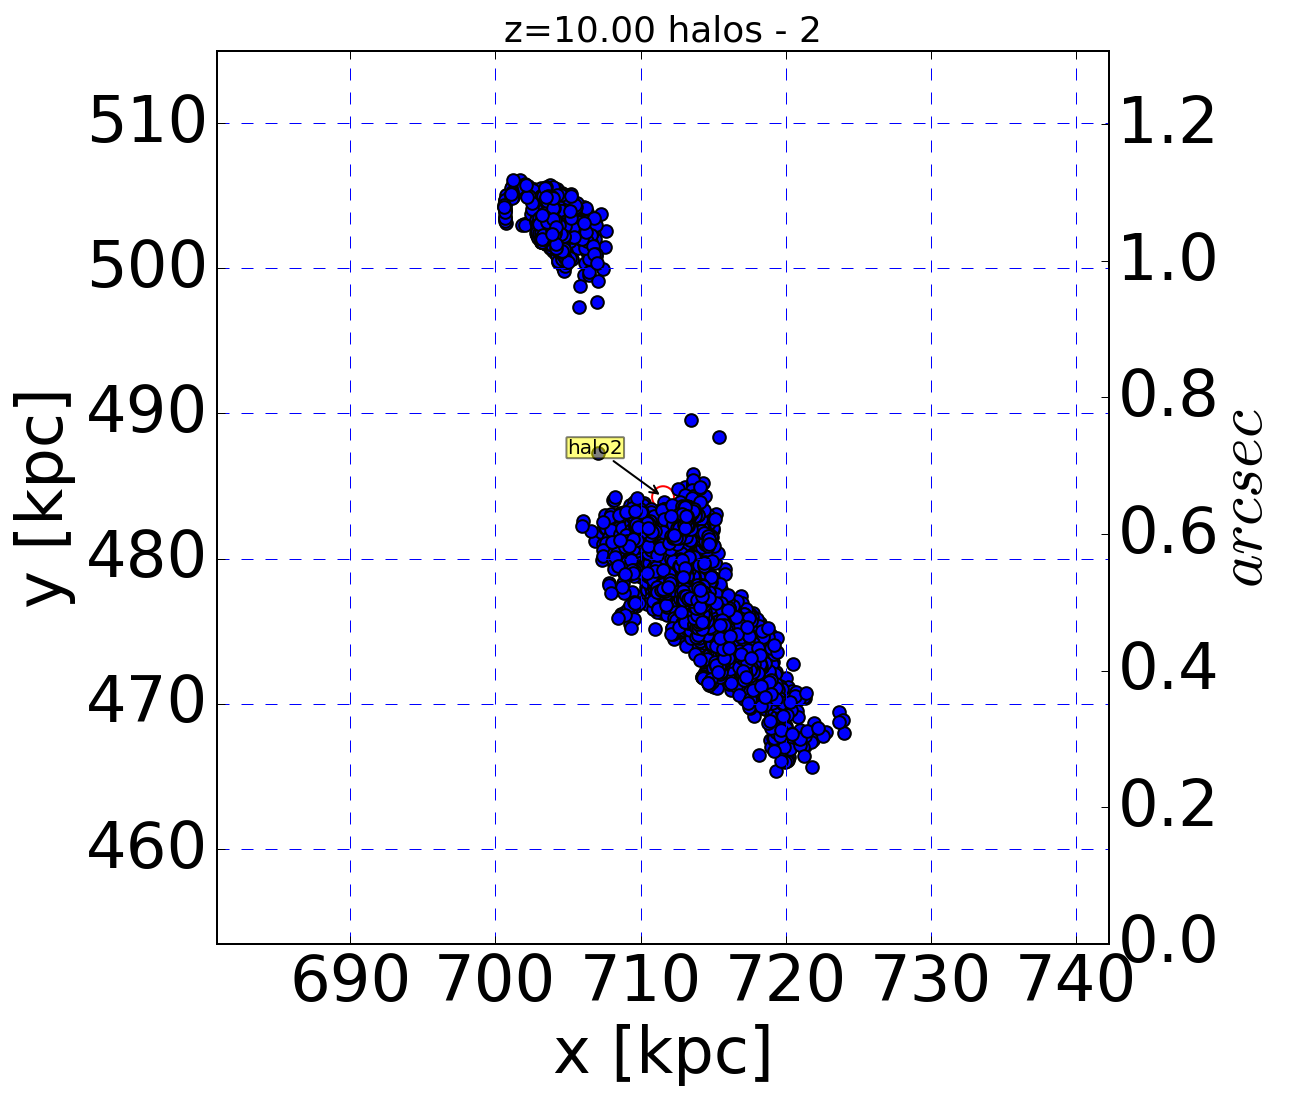

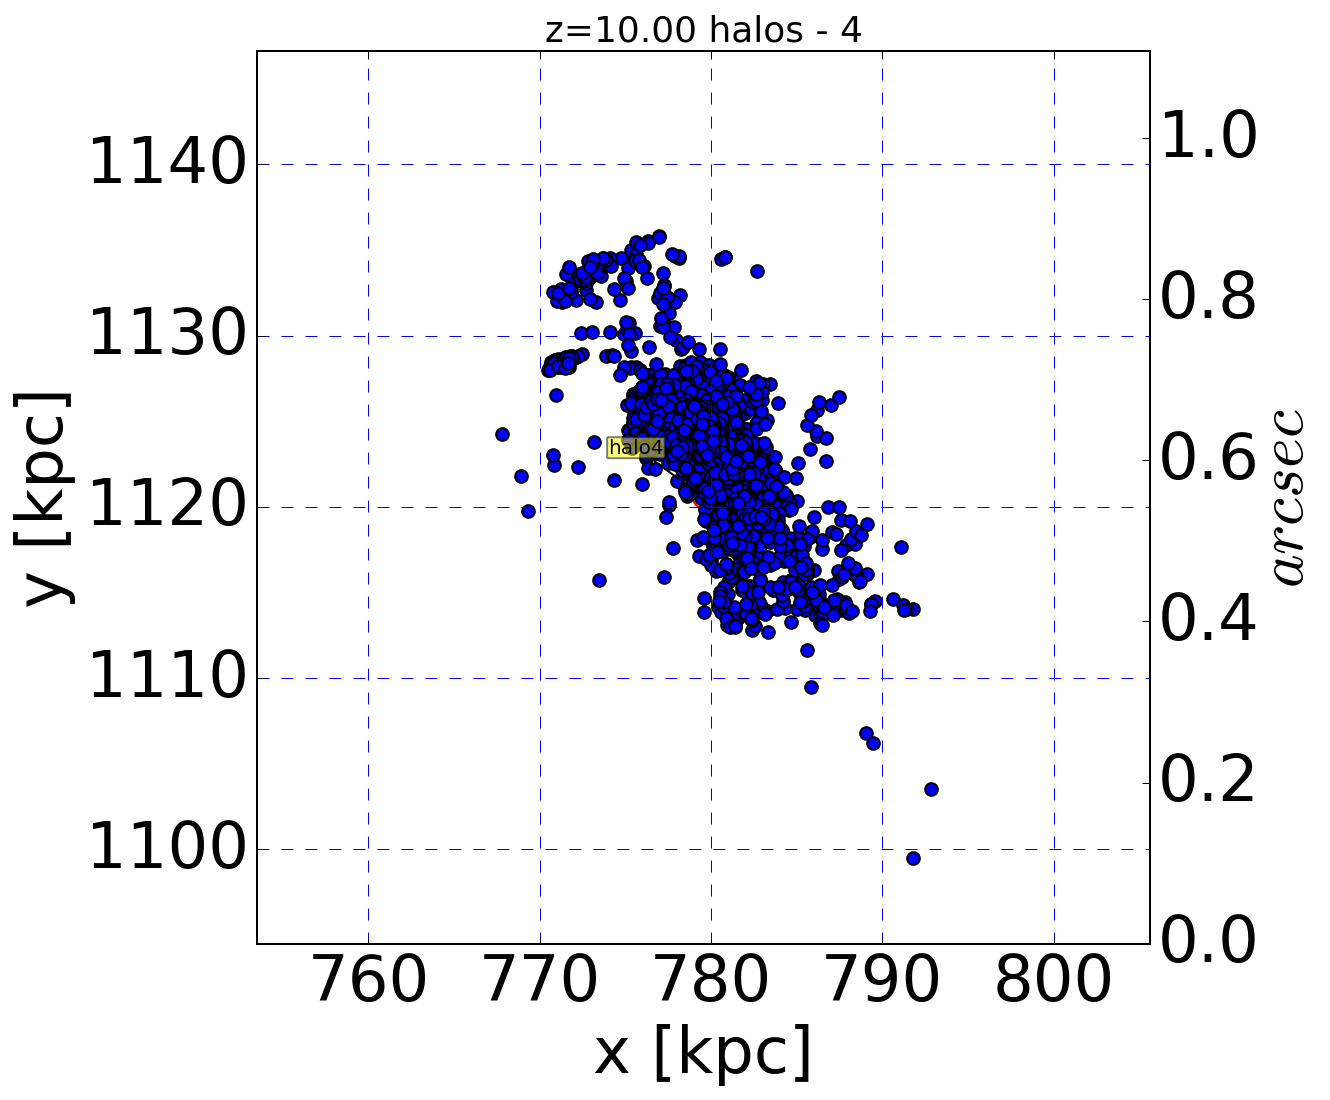

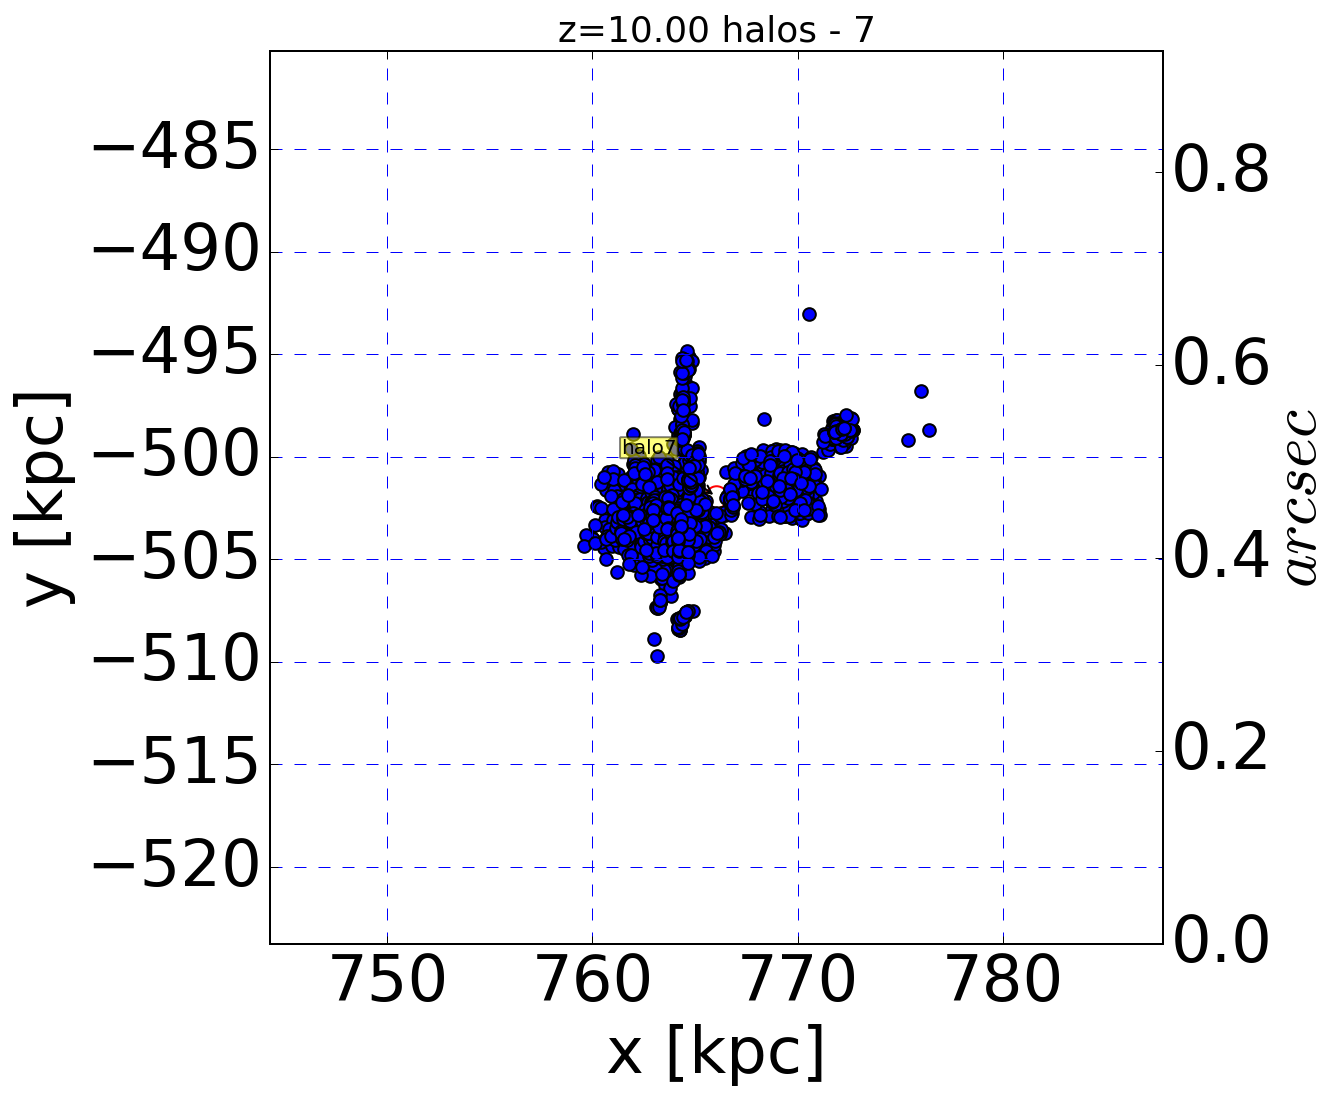

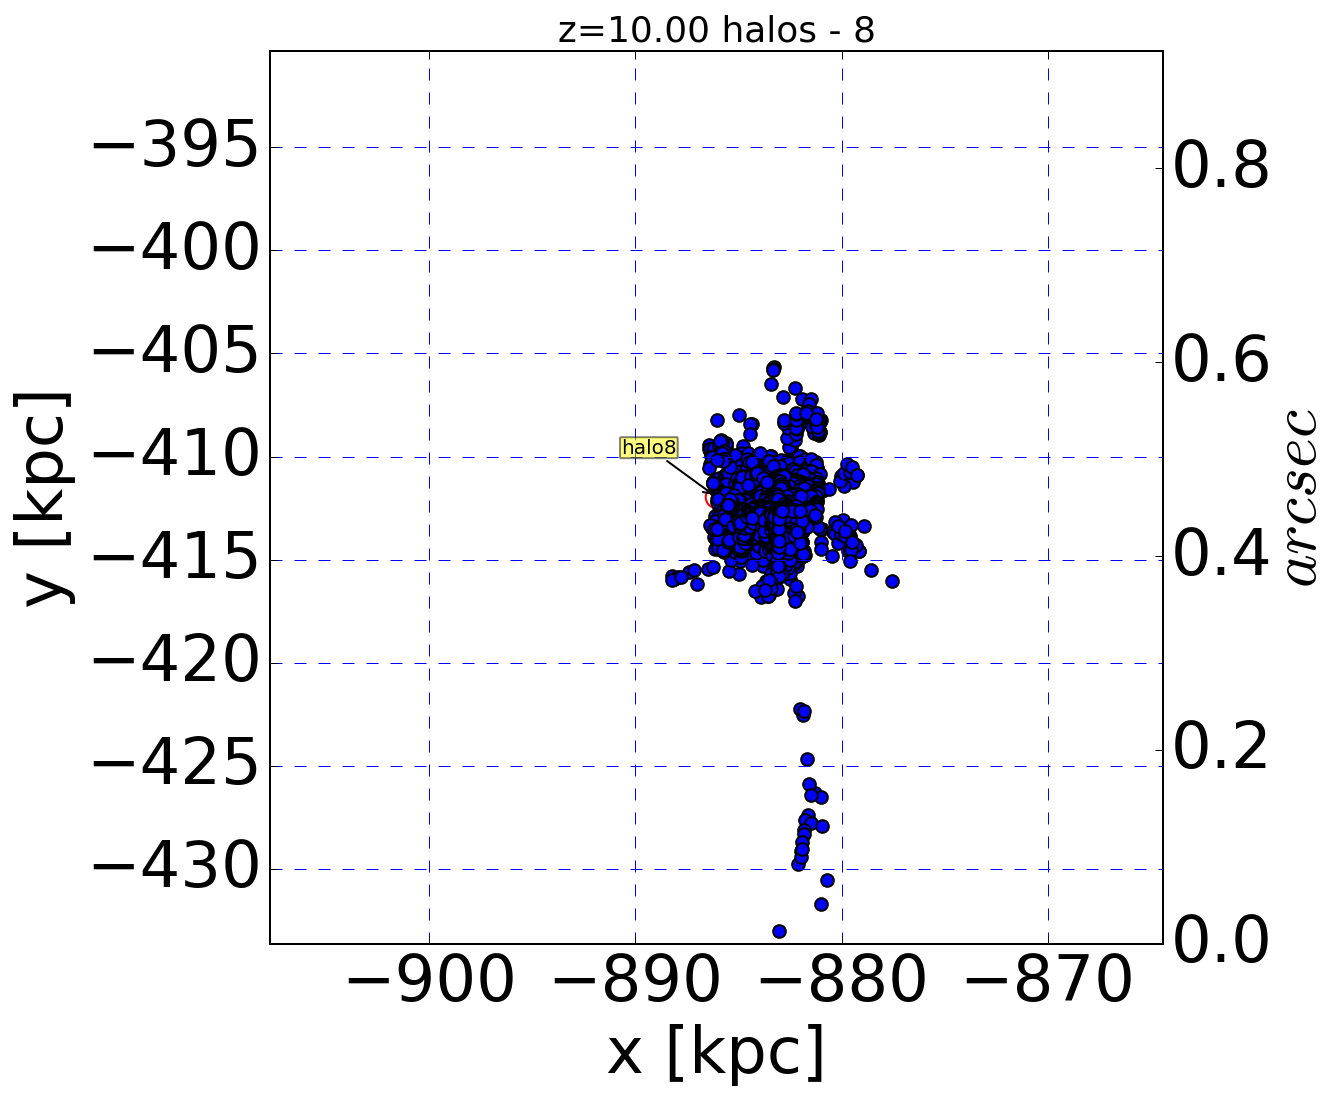

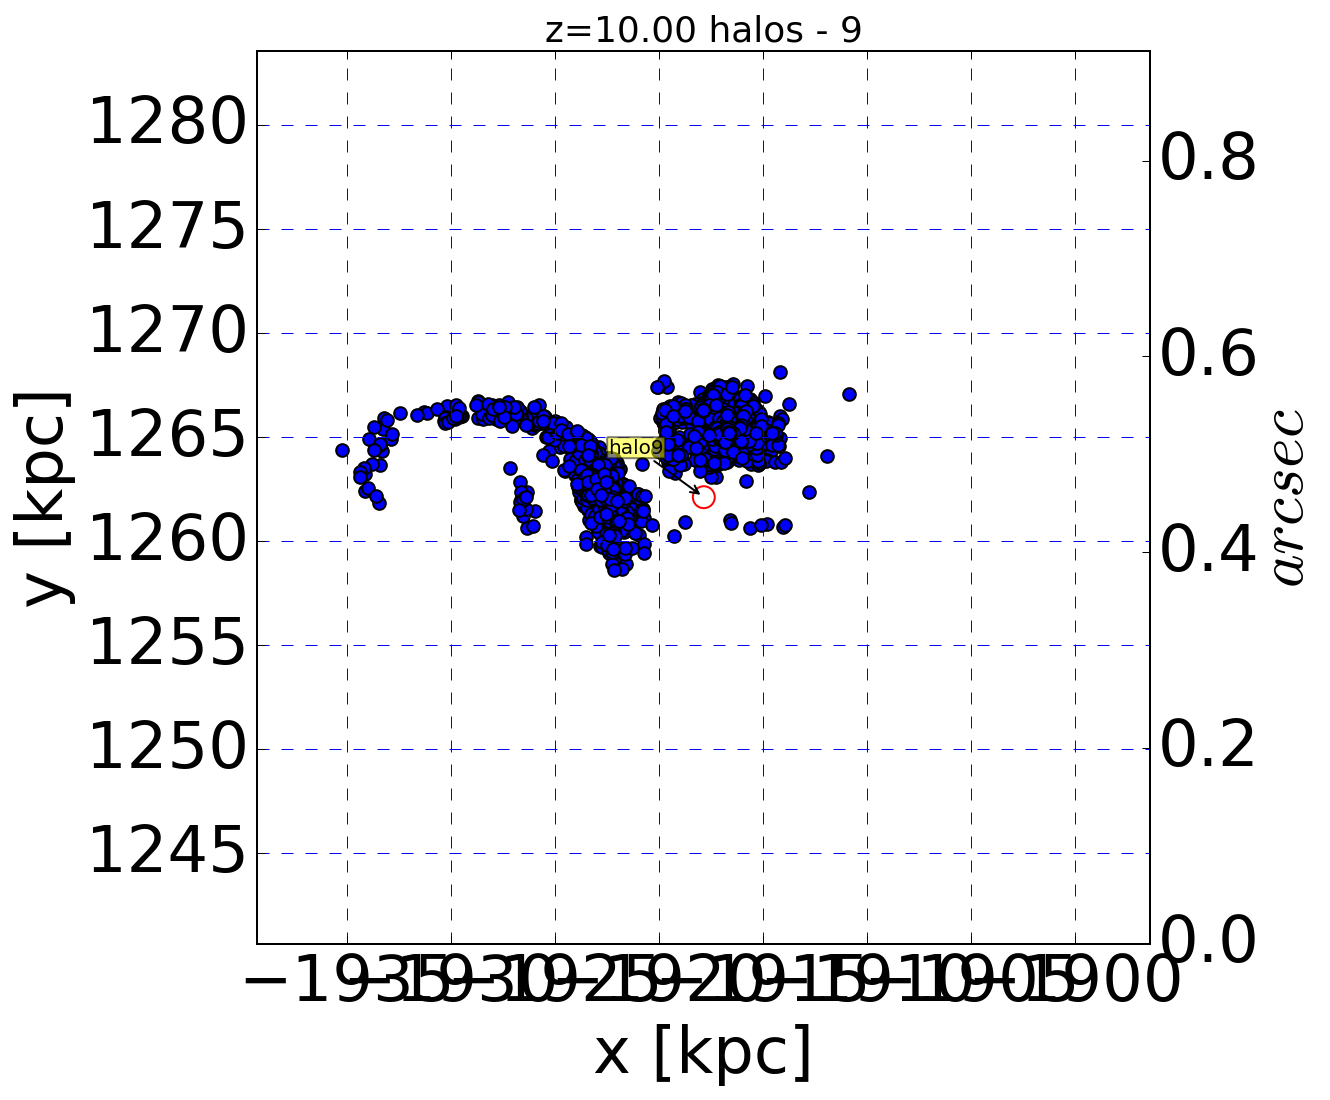

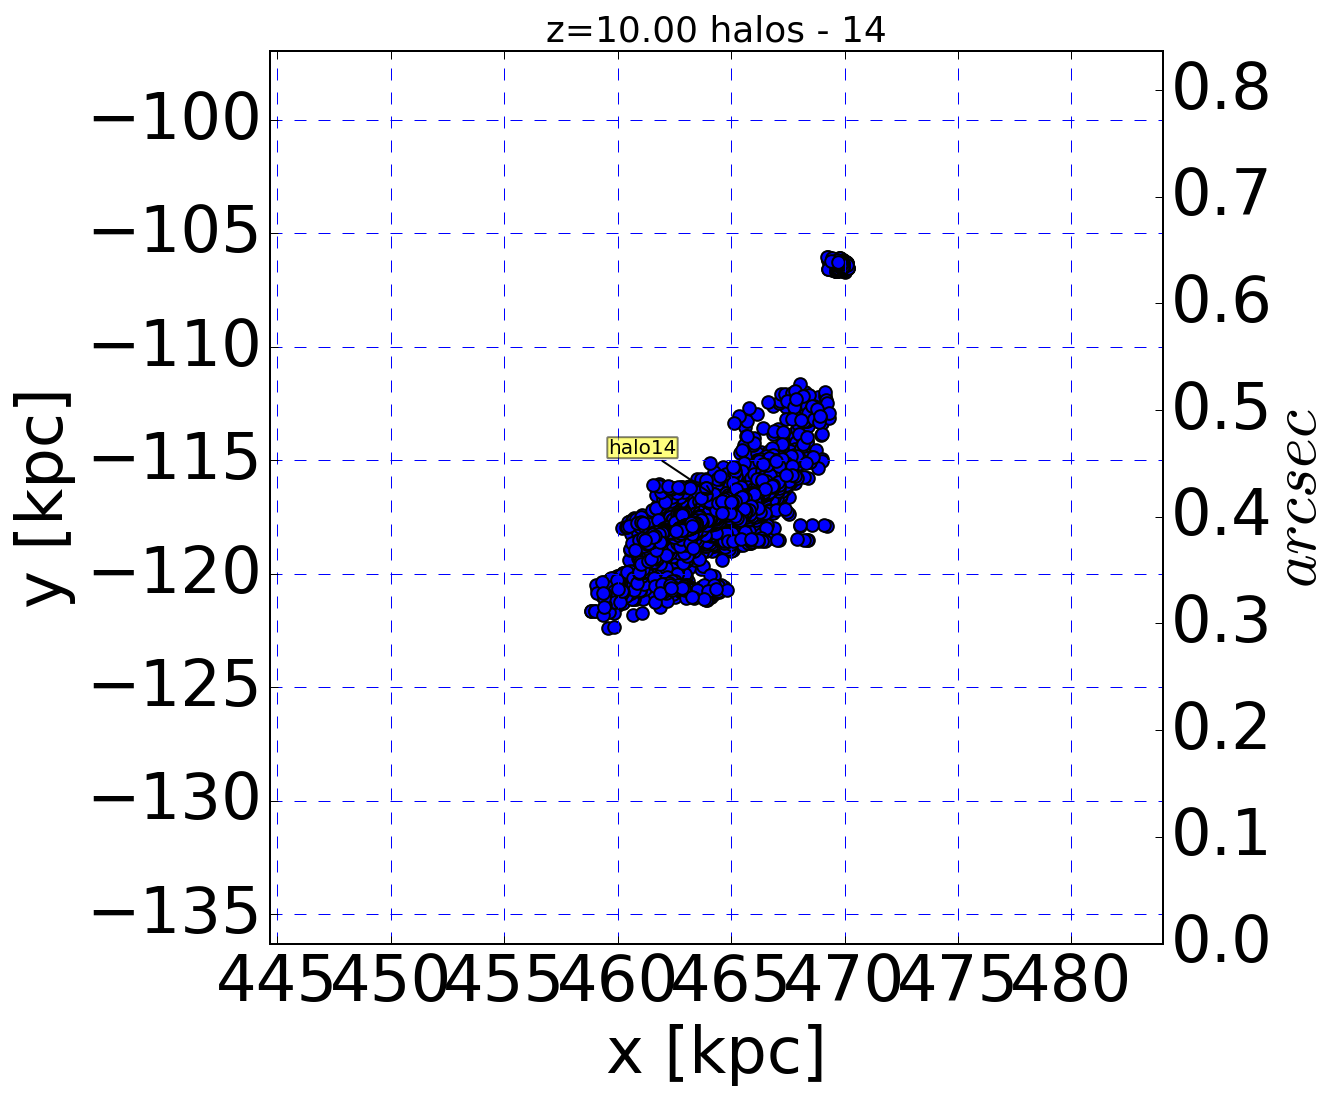

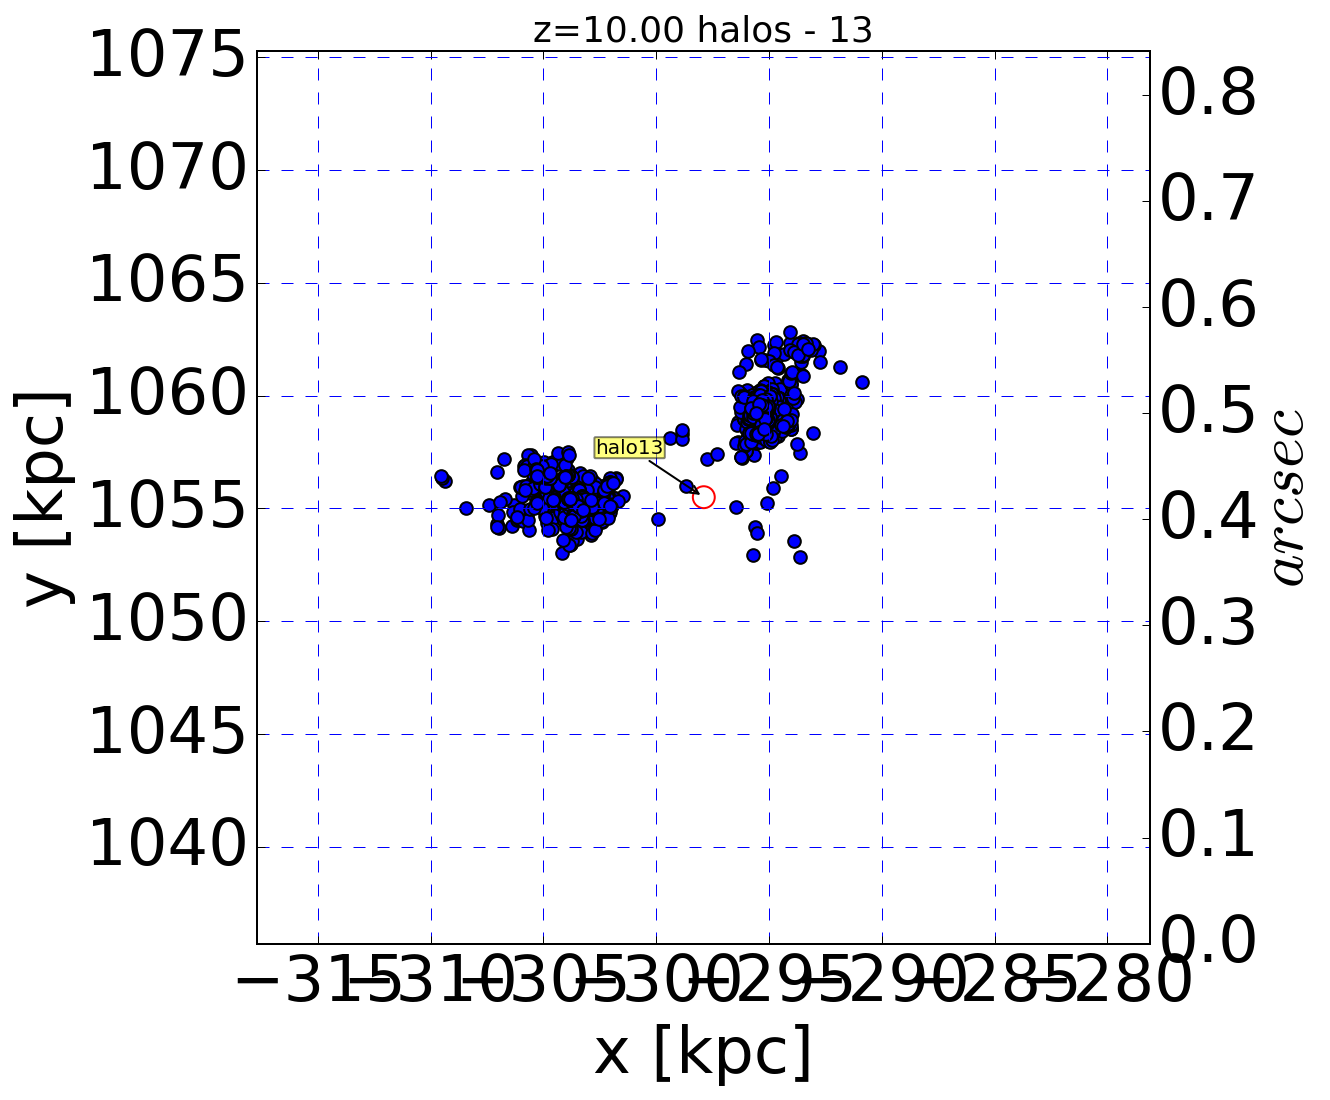

In [47]:
corresHalos = [1,0,3,2,4,7,8,9,14,13]
for halo in corresHalos:
    arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value  # compute arc sec per kpc at this z
    radiusScaleFac = 0.75 # Fraction of DM virial radius to count stars
    radius = ((totMass(halossizesDM['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100 ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPosDM,halo,r=radius)

    print('Halo {} r_v={:.2f} kpc, stellar mass={:.2e}, DM mass={:.2e}'.format(halo, radius,
                                                    np.sum(halomass),totMass(halossizesDM['count'][halo])))
    ax=halos.pltView(locs,halosPosDM,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    del ax
    gc.collect()

In [48]:
stellarMass=[1.88E+07,
1.20E+07,
9.80E+06,
8.70E+06,
6.14E+06,
5.80E+06,
4.51E+06,
3.51E+06,
3.40E+06,
1.98E+06]
dmMass=[1.20E+09,
1.46E+09,
9.61E+08,
1.19E+09,
7.26E+08,
4.23E+08,
4.17E+08,
4.05E+08,
3.12E+08,
3.18E+08]

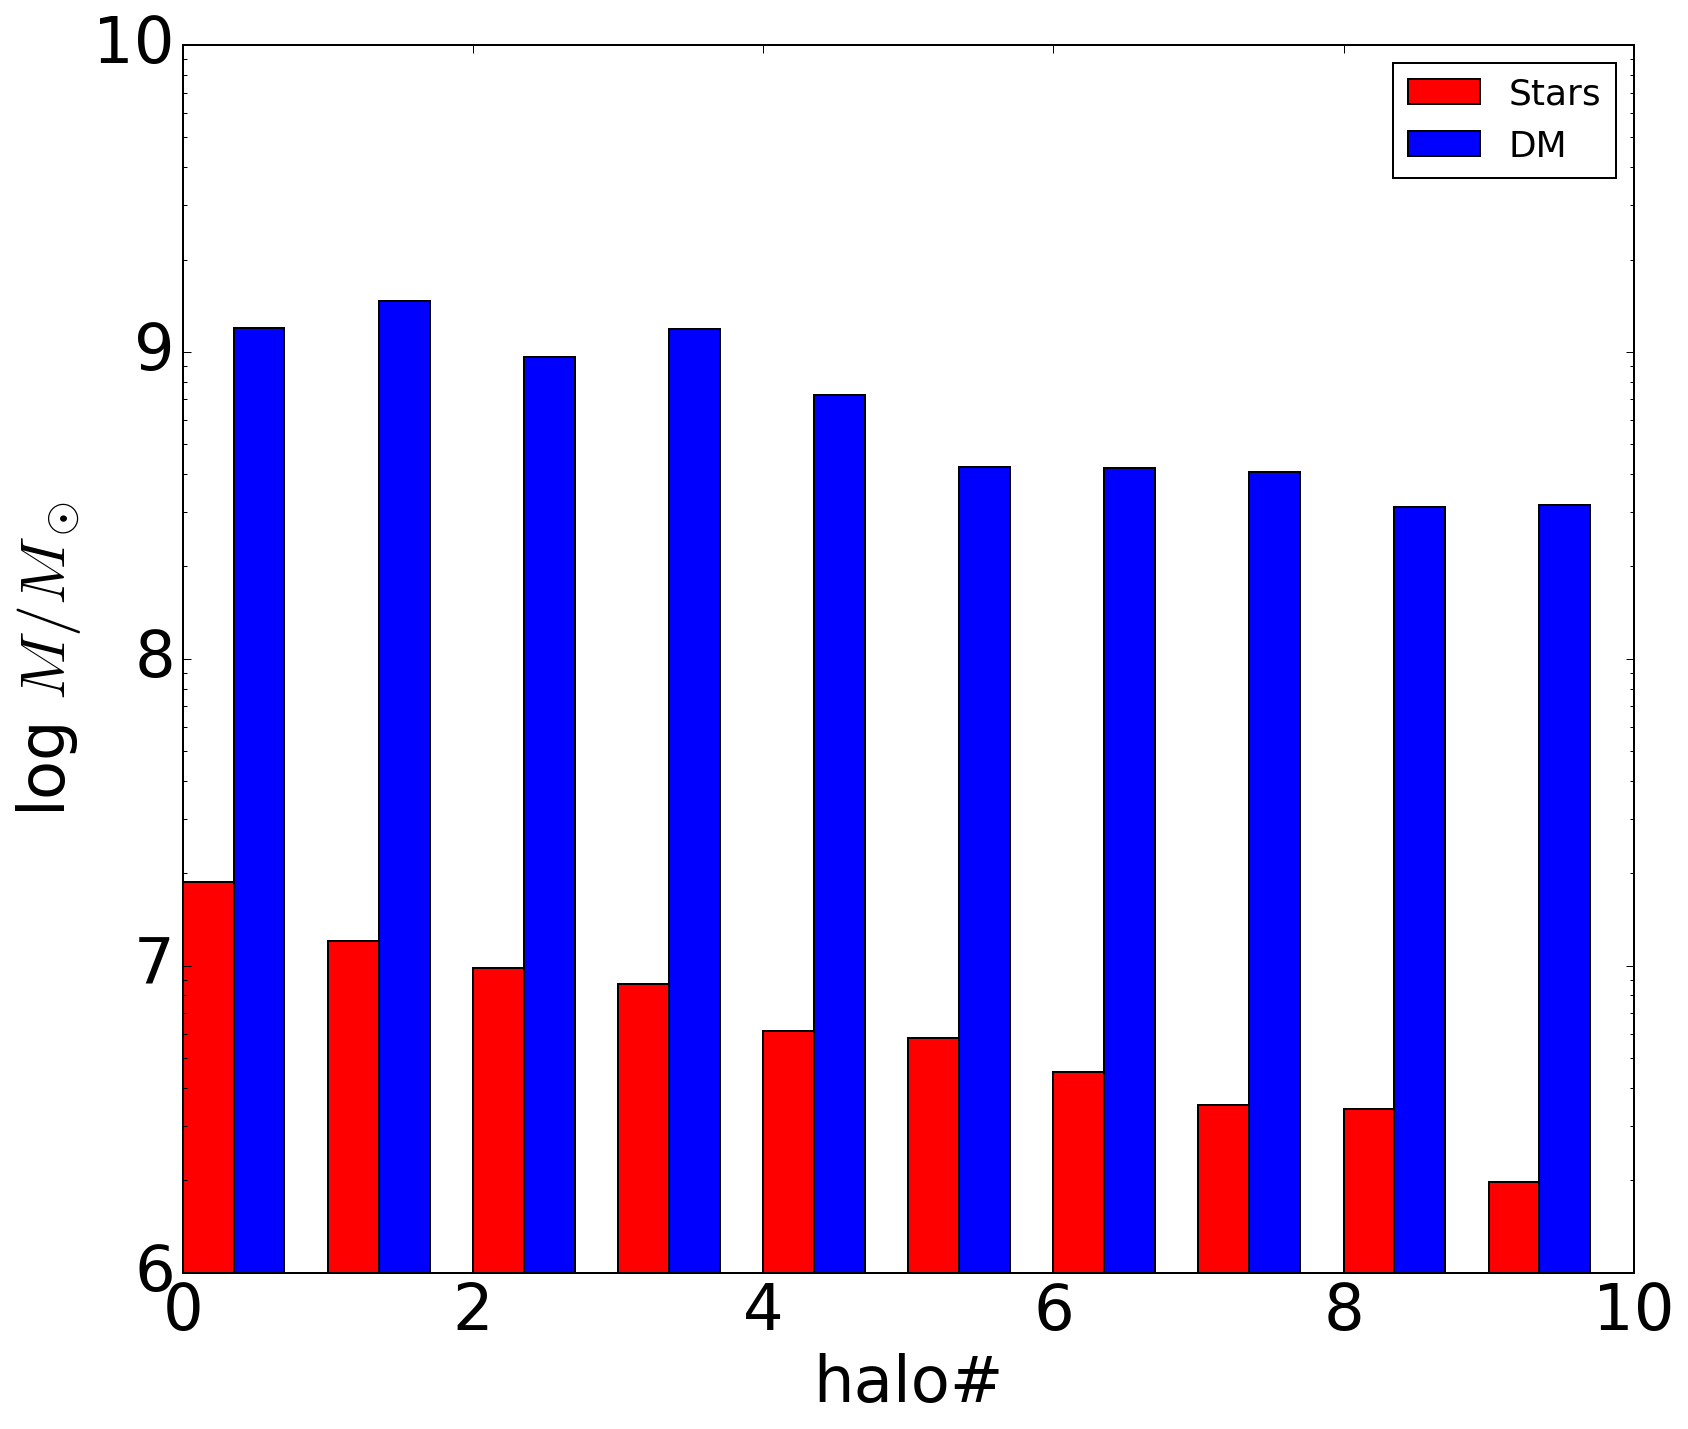

In [67]:
N     = len(stellarMass)
ind   = np.arange(N)  # the x locations for the groups
width = 0.35          # the width of the bars

fig = plt.figure()
ax = plt.axes()
stars = ax.bar(ind, stellarMass, width, color='r',label='Stars')
dmpar = ax.bar(ind+width, dmMass, width, color='b',label='DM')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)

ax.set_xlabel('halo#')
ax.set_ylabel('log $M/M_\odot$')

ax.legend(handles=[stars,dmpar],loc='upper right', fontsize=18 )
